In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import silhouette_score
from tqdm import tqdm

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Reading the data extracted from Face ++
image_data = pd.read_csv('face_detection_results.csv') 
image_data.head()

image_url  gender  age   smile  \
0  https://images.gofundme.com/M-BnG_r_dO1C9PG8Qu...  Female   34   1.729   
1  https://images.gofundme.com/jIk3PqXTfGhwFJPsOd...  Female   21   0.138   
2  https://images.gofundme.com/JprePUx9tJ9ZFKR-MI...  Female   77  84.192   
3  https://images.gofundme.com/QXM43jlP1AuOWgi2GN...  Female   61  99.979   
4  https://images.gofundme.com/V9UphwEdWH01t76Jlz...    Male   36  11.332   

                                             emotion  \
0  {'anger': 0.011, 'disgust': 0.011, 'fear': 0.2...   
1  {'anger': 0.0, 'disgust': 0.0, 'fear': 0.0, 'h...   
2  {'anger': 2.577, 'disgust': 0.419, 'fear': 0.0...   
3  {'anger': 0.0, 'disgust': 0.001, 'fear': 0.0, ...   
4  {'anger': 0.021, 'disgust': 0.006, 'fear': 0.0...   

                                           beauty  
0   {'female_score': 62.441, 'male_score': 61.97}  
1  {'female_score': 68.611, 'male_score': 73.114}  
2  {'female_score': 41.007, 'male_score': 36.117}  
3  {'female_score': 29.451, 'male_score': 27.211}  
4  {'female_score': 51.488, 'male_score': 53.464}

In [3]:
image_data.shape

(4531, 6)

It has 4531 rows and 6 columns

In [4]:
# Check if there any duplicate values in image_url
image_data[image_data['image_url'].duplicated()]

image_url gender  age  smile  \
3525  https://images.gofundme.com/DMenIYkUW5RzJq0uqA...   Male   37  0.105   

                                                emotion  \
3525  {'anger': 0.001, 'disgust': 99.248, 'fear': 0....   

                                              beauty  
3525  {'female_score': 53.057, 'male_score': 53.398}

Yes, there exits a duplicate record

In [5]:
# Dropping duplicate record
image_data_final = image_data.drop_duplicates(subset='image_url')
image_data_final.shape

(4530, 6)

After removing the duplicate record, data has 4530 rows and 6 columns

In [6]:
# Resetting the index of the dataframe
image_data_final.reset_index(drop=True,inplace = True)

In [7]:
def convert_to_dict(row):
    # convert a string representation of a dictionary into an actual Python dictionary
    row['emotion'] = ast.literal_eval(row['emotion'])
    row['beauty'] = ast.literal_eval(row['beauty'])
    return row

In [8]:
# applying the convert_to_dict function for the data
image_data_final = image_data_final.apply(convert_to_dict, axis=1)

In [9]:
# Extracting the emotion which has the maximum value
image_data_final["emotion"] = image_data_final["emotion"].apply(lambda x: max(x, key=x.get))

In [10]:
def beauty_score(row):
    # Extracts the beauty score of male/female based on the gender 
    # in the gender column
    if row['gender'].lower() == 'female':
        row['beauty'] = row['beauty']['female_score']
    else:
        row['beauty'] = row['beauty']['male_score']
    return row

In [11]:
# Applying the beauty_score function to the data.
image_data_final = image_data_final.apply(beauty_score, axis=1)

In [12]:
# Transforming the 'smile' column to categorize it based on a threshold
# If the value in 'smile' is greater than 50, label it as 'yes', otherwise label it as 'no'
image_data_final['smile'] =  image_data_final['smile'].apply(lambda x: 'yes' if x>50 else 'no') 
# Converting all text in the 'gender' column to lowercase
image_data_final['gender'] = image_data_final['gender'].apply(lambda x: x.lower())

In [13]:
# Converting the age column into age gropus with the below age limits
bins = [0, 14, 24, 64, 100]
labels = ['child', 'youth', 'adult', 'senior']
image_data_final['age_group'] = pd.cut(image_data_final['age'], bins=bins, labels=labels, right=True).astype('object')

In [14]:
# Dropping the age column
image_data_final.drop('age',axis=1,inplace=True)

In [15]:
# Displaying the first 5 rows of the column
image_data_final.head()

image_url  gender smile    emotion  \
0  https://images.gofundme.com/M-BnG_r_dO1C9PG8Qu...  female    no   surprise   
1  https://images.gofundme.com/jIk3PqXTfGhwFJPsOd...  female    no    neutral   
2  https://images.gofundme.com/JprePUx9tJ9ZFKR-MI...  female   yes    neutral   
3  https://images.gofundme.com/QXM43jlP1AuOWgi2GN...  female   yes  happiness   
4  https://images.gofundme.com/V9UphwEdWH01t76Jlz...    male    no    neutral   

   beauty age_group  
0  62.441     adult  
1  68.611     youth  
2  41.007    senior  
3  29.451     adult  
4  53.464     adult

In [16]:
# checking if there are any null values in any column
image_data_final.isnull().any()

image_url    False
gender       False
smile        False
emotion      False
beauty       False
age_group    False
dtype: bool

No null values in any column

***Merging Image data with gofundme data***

In [17]:
# reading the data extracted from campaign link pages
gofundme_data = pd.read_csv('processed_data_28th_oct.csv')

In [18]:
# Check if there any duplicate values in image_url
gofundme_data[gofundme_data['image_url'].duplicated()]

title  raised_amount  goal_amount        date_span  \
5983  help flood crisis              0         1500  Created 8 d ago   

                                                  story  no_of_donations  \
5983  flood crisis alarming affecting millions entir...              0.0   

                                              image_url     organizer  \
5983  https://images.gofundme.com/DMenIYkUW5RzJq0uqA...  Ashfi Rahman   

          location                                      campaign_link  \
5983  Brooklyn, NY  https://www.gofundme.com//f/help-bangladesh-fa...   

                    category state  duration_days  
5983  environment-fundraiser    NY              8

Yes, there exists a duplicate record

In [19]:
# Removing the duplicate record
gofundme_data = gofundme_data.drop_duplicates(subset='image_url')

In [20]:
# Checking if there are any null values in any column
gofundme_data.isnull().any()

title               True
raised_amount      False
goal_amount        False
date_span          False
story               True
no_of_donations    False
image_url          False
organizer          False
location           False
campaign_link      False
category           False
state              False
duration_days      False
dtype: bool

There exists null values in title and story columns

In [21]:
# Dropping null values
gofundme_data.dropna(axis=0,inplace=True)

In [22]:
gofundme_data.isnull().any()

title              False
raised_amount      False
goal_amount        False
date_span          False
story              False
no_of_donations    False
image_url          False
organizer          False
location           False
campaign_link      False
category           False
state              False
duration_days      False
dtype: bool

In [23]:
# Resetting the index of the dataframe
gofundme_data.reset_index(drop=True,inplace = True)

In [24]:
# Merging the gofundme and image_data dataframes
merged_data = pd.merge(gofundme_data, image_data_final, on='image_url', how='inner')
merged_data.head()

title  raised_amount  goal_amount  \
0                  get beryl            725          500   
1   help family reach safety           2281        30000   
2            support funeral           7430        15000   
3                       grow            275         2500   
4  help honor proper funeral           4585         5000   

                     date_span  \
0              Created 5 d ago   
1  Created September 9th, 2024   
2  Created September 9th, 2024   
3  Created September 5th, 2024   
4              Created 5 d ago   

                                               story  no_of_donations  \
0  help people get beryl east valley animal shelt...             23.0   
1  name year old living strip becoming less less ...            117.0   
2  please note calling father martin sleep young ...             54.0   
3  hello senior nursing university president vice...              4.0   
4  tragedy struck left try figure funeral son fat...             96.0   

                                           image_url       organizer  \
0  https://images.gofundme.com/M-BnG_r_dO1C9PG8Qu...  Noreen Goldner   
1  https://images.gofundme.com/jIk3PqXTfGhwFJPsOd...            I PB   
2  https://images.gofundme.com/JprePUx9tJ9ZFKR-MI...   Paul McNerney   
3  https://images.gofundme.com/QXM43jlP1AuOWgi2GN...  Mackenzie Wahl   
4  https://images.gofundme.com/V9UphwEdWH01t76Jlz...    John Vancise   

               location                                      campaign_link  \
0           Burbank, CA  https://www.gofundme.com//f/get-beryl-to-maine...   
1    Virginia Beach, VA  https://www.gofundme.com//f/helpmaryamfamily?q...   
2  Stafford Springs, CT  https://www.gofundme.com//f/support-for-robert...   
3          Danville, VA  https://www.gofundme.com//f/empower-future-nur...   
4              Erie, PA  https://www.gofundme.com//f/help-us-honor-john...   

               category state  duration_days  gender smile    emotion  beauty  \
0     animal-fundraiser    CA              5  female    no   surprise  62.441   
1  emergency-fundraiser    VA             13  female    no    neutral  68.611   
2   memorial-fundraiser    CT             13  female   yes    neutral  41.007   
3  education-fundraiser    VA             17  female   yes  happiness  29.451   
4   memorial-fundraiser    PA              5    male    no    neutral  53.464   

  age_group  
0     adult  
1     youth  
2    senior  
3     adult  
4     adult

In [25]:
# checking if there any null values in each column
merged_data.isnull().any()

title              False
raised_amount      False
goal_amount        False
date_span          False
story              False
no_of_donations    False
image_url          False
organizer          False
location           False
campaign_link      False
category           False
state              False
duration_days      False
gender             False
smile              False
emotion            False
beauty             False
age_group          False
dtype: bool

In [26]:
# Creating a ratio column as raised amount / goal amount 
merged_data['ratio'] = merged_data['raised_amount'] / merged_data['goal_amount']

In [27]:
# Creating subset of data whose ratio is less than 1 [whose raised amount is less than goal amount.]
subset_data = merged_data[merged_data['ratio'] < 1]

In [28]:
subset_data.reset_index(drop=True,inplace = True) 
subset_data.head()

title  raised_amount  goal_amount  \
0               help family reach safety           2281        30000   
1                        support funeral           7430        15000   
2                                   grow            275         2500   
3              help honor proper funeral           4585         5000   
4  show gratitude please donate birthday            170        10000   

                     date_span  \
0  Created September 9th, 2024   
1  Created September 9th, 2024   
2  Created September 5th, 2024   
3              Created 5 d ago   
4    Created August 28th, 2024   

                                               story  no_of_donations  \
0  name year old living strip becoming less less ...            117.0   
1  please note calling father martin sleep young ...             54.0   
2  hello senior nursing university president vice...              4.0   
3  tragedy struck left try figure funeral son fat...             96.0   
4  hey know joy inspiration dance many might real...              5.0   

                                           image_url           organizer  \
0  https://images.gofundme.com/jIk3PqXTfGhwFJPsOd...                I PB   
1  https://images.gofundme.com/JprePUx9tJ9ZFKR-MI...       Paul McNerney   
2  https://images.gofundme.com/QXM43jlP1AuOWgi2GN...      Mackenzie Wahl   
3  https://images.gofundme.com/V9UphwEdWH01t76Jlz...        John Vancise   
4  https://images.gofundme.com/Op5GnX0II1OujURS1X...  Alexander Gurevich   

               location                                      campaign_link  \
0    Virginia Beach, VA  https://www.gofundme.com//f/helpmaryamfamily?q...   
1  Stafford Springs, CT  https://www.gofundme.com//f/support-for-robert...   
2          Danville, VA  https://www.gofundme.com//f/empower-future-nur...   
3              Erie, PA  https://www.gofundme.com//f/help-us-honor-john...   
4          Brooklyn, NY  https://www.gofundme.com//f/show-gratitude-ple...   

               category state  duration_days  gender smile    emotion  beauty  \
0  emergency-fundraiser    VA             13  female    no    neutral  68.611   
1   memorial-fundraiser    CT             13  female   yes    neutral  41.007   
2  education-fundraiser    VA             17  female   yes  happiness  29.451   
3   memorial-fundraiser    PA              5    male    no    neutral  53.464   
4     wishes-fundraiser    NY             25    male    no  happiness  58.150   

  age_group     ratio  
0     youth  0.076033  
1    senior  0.495333  
2     adult  0.110000  
3     adult  0.917000  
4     adult  0.017000

In [29]:
subset_data.shape

(3994, 19)

So the data has 3994 rows.

In [30]:
# Combining the title column and story column to single text column.
subset_data['text']     = subset_data['title'] + ' '+ subset_data['story']
# Creating a word len column which extracts length of words from each text.
subset_data['word_len'] = subset_data['text'].apply(lambda x: len(x.split()))

In [31]:
gofund_urgency = subset_data[['text']].copy()

100%|███████████████████████████████████████████| 13/13 [00:05<00:00,  2.52it/s]


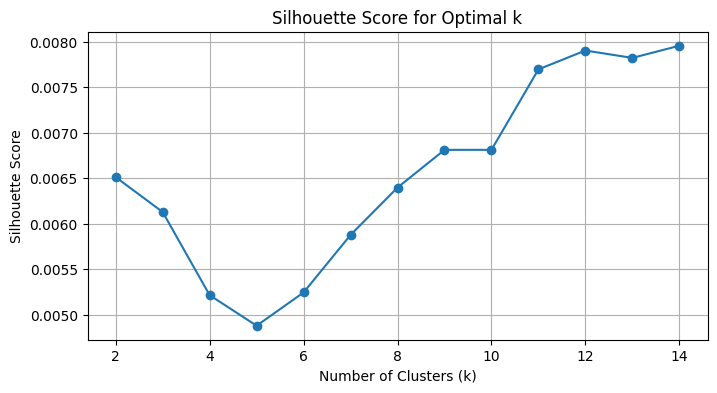

In [32]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(gofund_urgency['text'].values)

silhouette_scores = []
for k in tqdm(range(2, 15)):  # Silhouette Score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.show()

In [33]:
# Based on the elbow plot, the optimal number of clusters (k = 5)
optimal_k = 5 

# Fitting KMeans with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(X)

KMeans(n_clusters=5, random_state=42)

In [34]:
# Analyzing the top 10 keywords in each cluster
# identifying the most frequent or significant words in the textual data that define each cluster. 
# This helps us interpret and understand the core themes or topics within each group.

top_keywords = []
for cluster in tqdm(range(5)):
    top_keywords.append([vectorizer.get_feature_names_out()[i] 
                         for i in kmeans_optimal.cluster_centers_.argsort()[:, -10:][cluster]])

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 28.51it/s]


In [35]:
# top 10 keywords in each cluster 
for i, keywords in enumerate(top_keywords):
    print(f"Cluster {i+1}: {', '.join(keywords)}")

Cluster 1: project, thank, need, new, make, would, school, community, support, help
Cluster 2: know, home, support, life, would, get, time, family, cancer, help
Cluster 3: experience, church, school, support, would, opportunity, help, god, mission, trip
Cluster 4: memory, father, difficult, life, loss, time, support, help, funeral, family
Cluster 5: travel, journey, dance, national, competition, world, help, compete, support, team


| **Cluster** | **Keywords**                               | **Urgency Level**      | **Reason**| 
|-------------|--------------------------------------------|------------------------|-----------|
| 1   | project, community, school, support        | Medium         |The language suggests planned projects or ongoing community support which typically are not emergencies.
| 2   | cancer, family, home, support              | High           |The association with health and family crises suggests an immediate and pressing need for support.
| 3   | mission, church, opportunity, experience   | Medium         |The focus is on opportunities (like mission trips or school projects) which are important but not typically urgent.
| 4   | funeral, loss, memory, family              | High           |Funerals and sudden losses are time-sensitive, making this cluster high urgency.
| 5   | competition, travel, team, journey         | Low            |The language is centered around planned events and competitions, which are generally not emergencies.

In [36]:
gofund_urgency['cluster'] = kmeans_optimal.predict(X)

In [37]:
def urgency_category(x):
    if x in [2, 4]:
        return 'high'
    elif x in [1, 3]:
        return 'medium'
    else:
        return 'low'

In [38]:
subset_data['urgency'] = gofund_urgency['cluster'].apply(urgency_category)

In [39]:
def remove_outliers(df, column):
    Q1  = df[column].quantile(0.005)
    Q3  = df[column].quantile(0.995)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [40]:
subset_data = remove_outliers(subset_data, 'goal_amount')

In [41]:
subset_data.reset_index(drop=True,inplace = True) 

In [42]:
# Dropped 'title','story','date_span','image_url','organizer','location','campaign_link' 
# columns for now as they don't find to be relevant. 
final_data = subset_data.drop(columns = ['title','story','date_span','image_url',
                                         'organizer','location','campaign_link'],axis=1)
final_data.head()

raised_amount  goal_amount  no_of_donations              category state  \
0           2281        30000            117.0  emergency-fundraiser    VA   
1           7430        15000             54.0   memorial-fundraiser    CT   
2            275         2500              4.0  education-fundraiser    VA   
3           4585         5000             96.0   memorial-fundraiser    PA   
4            170        10000              5.0     wishes-fundraiser    NY   

   duration_days  gender smile    emotion  beauty age_group     ratio  \
0             13  female    no    neutral  68.611     youth  0.076033   
1             13  female   yes    neutral  41.007    senior  0.495333   
2             17  female   yes  happiness  29.451     adult  0.110000   
3              5    male    no    neutral  53.464     adult  0.917000   
4             25    male    no  happiness  58.150     adult  0.017000   

                                                text  word_len urgency  
0  help family reach safety name year old living ...       201  medium  
1  support funeral please note calling father mar...       232  medium  
2  grow hello senior nursing university president...       178     low  
3  help honor proper funeral tragedy struck left ...        35  medium  
4  show gratitude please donate birthday hey know...        71     low

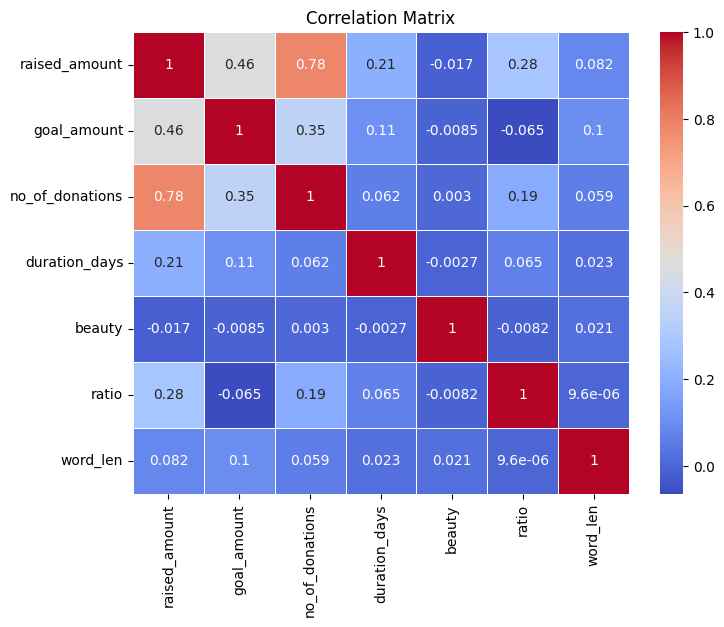

In [43]:
corr_matrix = final_data.corr(numeric_only=True)

# Plotting the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [44]:
final_data.dtypes

raised_amount        int64
goal_amount          int64
no_of_donations    float64
category            object
state               object
duration_days        int64
gender              object
smile               object
emotion             object
beauty             float64
age_group           object
ratio              float64
text                object
word_len             int64
urgency             object
dtype: object

In [45]:
final_data.shape

(3986, 15)

In [46]:
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=128, window=5, min_count=3):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None
        self.vocabulary = []  # To store the vocabulary of words

    def fit(self, X, y=None):
        # Tokenize the text data
        tokenized_texts = [text.split() for text in X]
        # Train Word2Vec model
        self.model = Word2Vec(sentences=tokenized_texts, vector_size=self.vector_size, 
                              window=self.window, min_count=self.min_count, epochs=10, workers=4)
        
        # Store the vocabulary
        self.vocabulary = list(self.model.wv.key_to_index.keys())  # Get words in the vocabulary
        return self

    def transform(self, X):
        # Convert text to Word2Vec vectors and return as a sparse matrix
        dense_matrix = np.array([self.get_vector(text) for text in X])
        # Convert to sparse matrix (CSR format)
        return csr_matrix(dense_matrix)

    def get_vector(self, text):
        # Average the vectors for all words in the text
        words = text.split()
        word_vectors = [self.model.wv[word] for word in words if word in self.model.wv]
        if word_vectors:
            return np.mean(word_vectors, axis=0)  # Return averaged word vectors as NumPy array
        else:
            return np.zeros(self.vector_size)  # Return zero vector if no words are found

    def get_feature_names_out(self, input_features=None):
        # Generate feature names based on the vocabulary
        # Limit to the first 'vector_size' words or pad with zeros if necessary
        if len(self.vocabulary) < self.vector_size:
            return self.vocabulary + [f'unknown_{i}' for i in range(self.vector_size - len(self.vocabulary))]
        else:
            return self.vocabulary[:self.vector_size]  # Return only the top 'vector_size' words

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import loguniform, randint, uniform
from sklearn.neural_network import MLPRegressor

In [48]:
def create_pipeline_and_search(
                        preprocessor, 
                        model, 
                        param_distributions, 
                        X_train, 
                        y_train, 
                        X_test, 
                        y_test, 
                        n_iter=3, 
                        cv=2,  
                        refit='R2', 
                        random_state=42, 
                        verbose=2):
    
    """
    Creates a pipeline with the given preprocessor and model, performs RandomizedSearchCV, 
    and returns the best model.

    Parameters:
    - preprocessor: ColumnTransformer for data preprocessing
    - model: Regressor model
    - param_distributions: Dictionary of hyperparameter distributions for RandomizedSearchCV
    - X_train, y_train, X_test, y_test: Training and test datasets
    - n_iter: Number of parameter settings sampled (default is 3)
    - cv: Number of cross-validation folds (default is 2)
    - scoring: Dictionary of scoring metrics (default is regression metrics)
    - refit: Metric to refit on (default is 'R2')
    - random_state: Random state for reproducibility (default is 42)
    - verbose: Verbosity level for RandomizedSearchCV (default is 2)

    Returns:
    - best_model: The fitted model with the best found parameters
    """
    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)])
    
    scoring = {'R2': make_scorer(r2_score)}  # R2 score for Regression
    
    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(
                    pipeline, param_distributions, n_iter=n_iter, scoring=scoring, refit=refit, cv=cv,
                    random_state=random_state, verbose=verbose)
    
    # Fit the model
    random_search.fit(X_train, y_train)
    
    # Predictions on train set and calculate train metrics
    y_pred_train = random_search.predict(X_train)
    
    mse_train    = mean_squared_error(y_train, y_pred_train)
    mae_train    = mean_absolute_error(y_train, y_pred_train)
    r2_train     = r2_score(y_train, y_pred_train)

    # Predictions on test set and calculate test metrics
    y_pred_test = random_search.predict(X_test)
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test  = r2_score(y_test, y_pred_test)

    # Get the best model for future predictions
    best_model = random_search.best_estimator_

    # Store results in a dictionary
    result = {
        'best_model': best_model,
        'metrics': {
                   'train_mse': mse_train,
                   'train_mae': mae_train,
                   'train_r2': r2_train,
                   'test_mse': mse_test,
                   'test_mae': mae_test,
                   'test_r2': r2_test
                   }
              }
    
    return result

In [49]:
# Splitting the final data into train and test in the ratio of 75:25 respectively 
X_train, X_test = train_test_split(final_data, test_size=0.25, random_state=42)

In [50]:
def get_the_results(X_train, X_test, param_grid=None, numerical_features=None, 
                    categorical_features=None, text_feature=None,
                    columns_drop_list=None,target_list=None):

    numerical_transformer   = Pipeline(steps=[
                            ('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    tfidf_transformer      = Pipeline(steps=[
                            ('tfidf', TfidfVectorizer(max_features=128))])
    
    preprocessor_tfidf   = ColumnTransformer(
                            transformers = [
                            ('num', numerical_transformer, numerical_features),       # Numerical features
                            ('cat', categorical_transformer, categorical_features),   # Categorical features
                            ('text_tfidf', tfidf_transformer, text_feature),          # text feature
                            ])
    
    w2v_transformer   = Pipeline(steps=[('w2v', Word2VecTransformer(vector_size=128))])
    
    preprocessor_w2v  = ColumnTransformer(
                            transformers = [
                            ('num', numerical_transformer, numerical_features),       # Numerical features
                            ('cat', categorical_transformer, categorical_features),   # Categorical features
                            ('text_w2v', w2v_transformer,text_feature),               # text feature
                            ])
    
    
    X_tr  = X_train.drop(columns_drop_list,axis=1)
    X_te  = X_test.drop(columns_drop_list,axis=1)

    y_tr  = np.log1p(X_train[target_list])
    y_te  = np.log1p(X_test[target_list])

    results_tfidf = {
    'train_mse' : np.zeros(7),
    'train_mae' : np.zeros(7),
    'train_r2'  : np.zeros(7),
    'test_mse'  : np.zeros(7),
    'test_mae'  : np.zeros(7),
    'test_r2'   : np.zeros(7)}
    
    trained_models = {}
    random_state = 24
    
    models = {
             'Ridge'   :Ridge(),
             'KNearest':KNeighborsRegressor(),
             'DecisionTree'  : DecisionTreeRegressor(),
             'RandomForest'  : RandomForestRegressor(),
             'GradientBoost' : GradientBoostingRegressor(),
             'XGBoost'       : XGBRegressor(),
             'MLP'           : MLPRegressor()  
              }
    
    for i,(name, model) in enumerate(models.items()):
        model_result  = create_pipeline_and_search(
                      preprocessor_tfidf, 
                      model, 
                      param_grid[name], 
                      X_tr, 
                      y_tr, 
                      X_te, 
                      y_te, 
                      n_iter=3, 
                      cv=2,
                      refit='R2', 
                      random_state=random_state, 
                      verbose=0)
    
        for metric, value in model_result['metrics'].items():
            results_tfidf[metric][i] = value
        trained_models[f'{name}_tfidf'] =  model_result['best_model']  
    
    if len(text_feature) != 0:
        
        results_w2v = {
                    'train_mse' : np.zeros(7),
                    'train_mae' : np.zeros(7),
                    'train_r2'  : np.zeros(7),
                    'test_mse'  : np.zeros(7),
                    'test_mae'  : np.zeros(7),
                    'test_r2'   : np.zeros(7)}
        
        for i,(name, model) in enumerate(models.items()):
            model_result  = create_pipeline_and_search(
                                   preprocessor_w2v, 
                                   model, 
                                   param_grid[name], 
                                   X_tr, 
                                   y_tr, 
                                   X_te, 
                                   y_te, 
                                   n_iter=3, 
                                   cv=2,
                                   refit='R2', 
                                   random_state=random_state, 
                                   verbose=0)
            for metric, value in model_result['metrics'].items():
                results_w2v[metric][i] = value
            trained_models[f'{name}_w2v'] =  model_result['best_model']
    
    if len(text_feature) != 0:
        
        df1 = pd.DataFrame(results_tfidf)
        df2 = pd.DataFrame(results_w2v)
        
        plt.figure(figsize=(18, 15))
        bar_width = 0.35
        index = np.arange(len(df1))

        for i, metric in enumerate(list(results_w2v.keys())):
            ax = plt.subplot(2, 3, i + 1)
            bars1 = ax.bar(index - bar_width / 2, df1[metric], width=bar_width, label='TFIDF', color='b')
            bars2 = ax.bar(index + bar_width / 2, df2[metric], width=bar_width, label='W2V', color='r')
            ax.set_title(metric)
            ax.set_xticks(index)
            ax.set_xticklabels(list(models.keys()),rotation=90)
            ax.legend()

            # Adding value labels using ax.containers
            for container in ax.containers:
                ax.bar_label(container, fmt='%.2f', padding=3, rotation=90, label_type='center', 
                         color= 'white', fontweight='bold')
    
        plt.tight_layout()
        plt.show()
    else:
        df = pd.DataFrame(results_tfidf)
        
        plt.figure(figsize=(18, 15))
        bar_width = 0.35
        index = np.arange(len(df))

        for i, metric in enumerate(list(results_tfidf.keys())):
            ax = plt.subplot(2, 3, i + 1)
            bars1 = ax.bar(index - bar_width / 2, df[metric], width=bar_width, color='b')
            ax.set_title(metric)
            ax.set_xticks(index)
            ax.set_xticklabels(list(models.keys()),rotation=90)

            # Adding value labels using ax.containers
            for container in ax.containers:
                ax.bar_label(container, fmt='%.2f', padding=3, rotation=90, label_type='center', 
                         color= 'white', fontweight='bold')
    
        plt.tight_layout()
        plt.show()
    
    return trained_models

***Modelling for predicting the no of donations***

In [51]:
param_grid = {
             'Ridge': {'regressor__alpha': loguniform(1e-5, 1e5)},
             'KNearest' : {'regressor__n_neighbors': [1, 3, 5, 7, 9, 11, 15]},
             'DecisionTree': {'regressor__max_depth': [2, 5, 10, 15, 20, 50]}, 
             'RandomForest': {
                             'regressor__n_estimators': randint(2, 30),    # Number of trees
                             'regressor__max_depth': randint(3, 10),         # Depth of trees
                             },
             'GradientBoost' : {
                             'regressor__n_estimators': randint(2, 10),    # Number of trees
                             'regressor__max_depth': randint(3, 10),         # Depth of trees
                             }, 

             'XGBoost'     : {
                             'regressor__n_estimators': randint(3, 10),     # Number of boosting rounds
                             'regressor__max_depth': randint(3, 6),          # Depth of each tree
                             },
             'MLP'         : {
                              'regressor__hidden_layer_sizes': [(50,), (100,), (100, 50)],  # different layer configurations
                              'regressor__activation': ['relu', 'tanh'],
                              'regressor__alpha': loguniform(1e-5, 1e-2),  # regularization strength
                              'regressor__learning_rate': ['constant', 'adaptive']
                              } 
                      }

In [52]:
num_features_donations    = X_train.drop(['no_of_donations','raised_amount'],
                                         axis=1).select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features_donations    = [i for i in X_train.select_dtypes(include=['object']).columns.tolist()
                                       if i != 'text']
text_feature              = 'text'

print('The numerical features are:')
for i in num_features_donations:
    print('   ' + i)
print('')    
print('The categorical features are:')
for i in cat_features_donations:
    print('   ' + i)
print('')    
print('The text features are:')
print('   ' + text_feature)

The numerical features are:
   goal_amount
   duration_days
   beauty
   ratio
   word_len

The categorical features are:
   category
   state
   gender
   smile
   emotion
   age_group
   urgency

The text features are:
   text


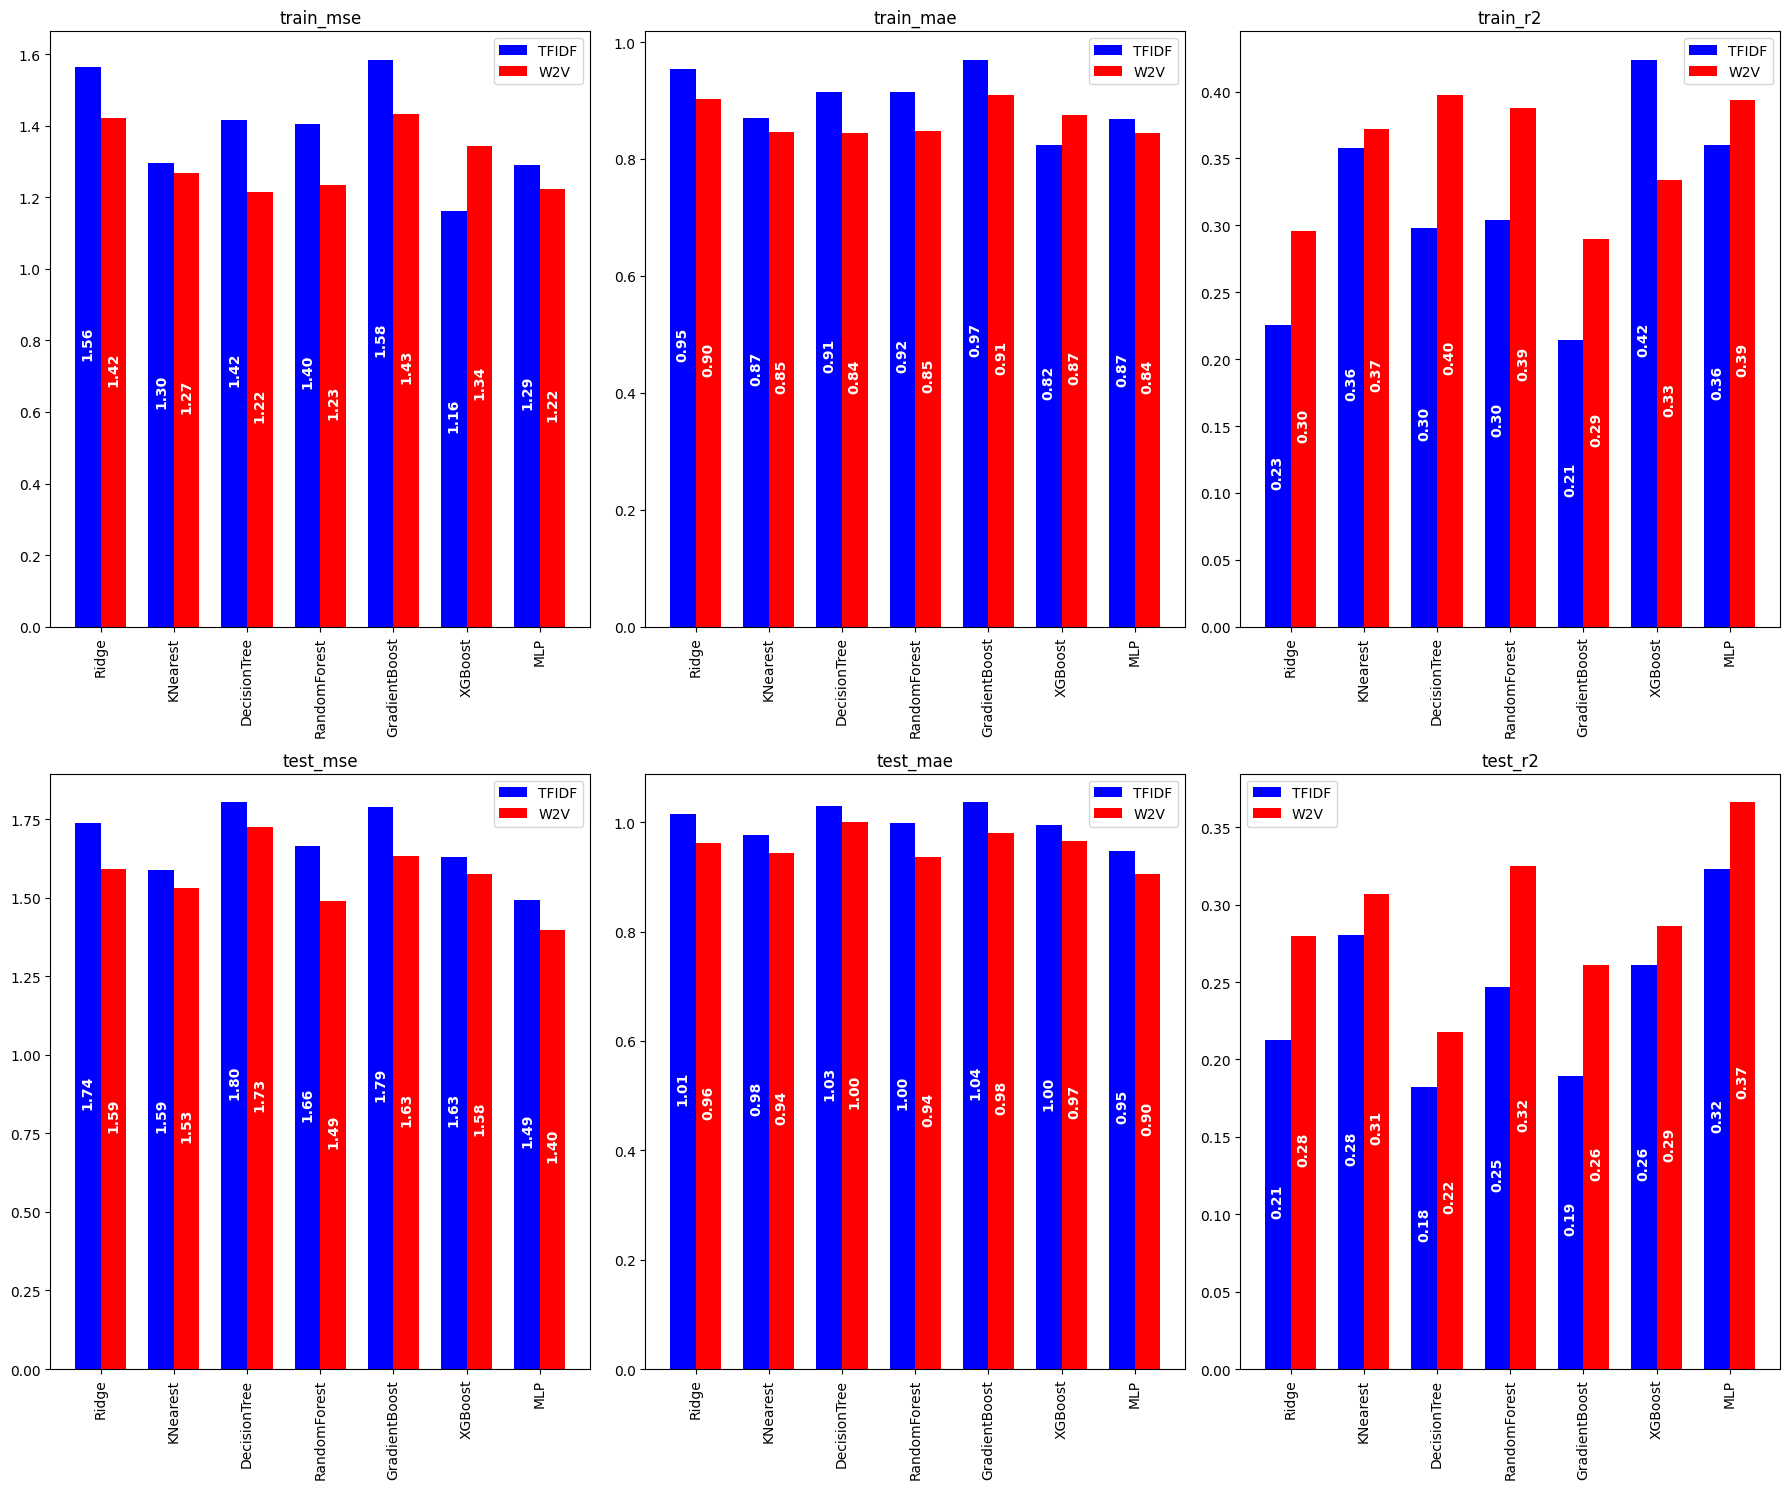

In [53]:
# Results for only text feature for predicting the no of donations.

donations_models_text = get_the_results(X_train, X_test, param_grid, 
                                      numerical_features   = [], 
                                      categorical_features = [], 
                                      text_feature         = text_feature,
                                      columns_drop_list    = ['no_of_donations','raised_amount'],
                                      target_list          = ['no_of_donations'])

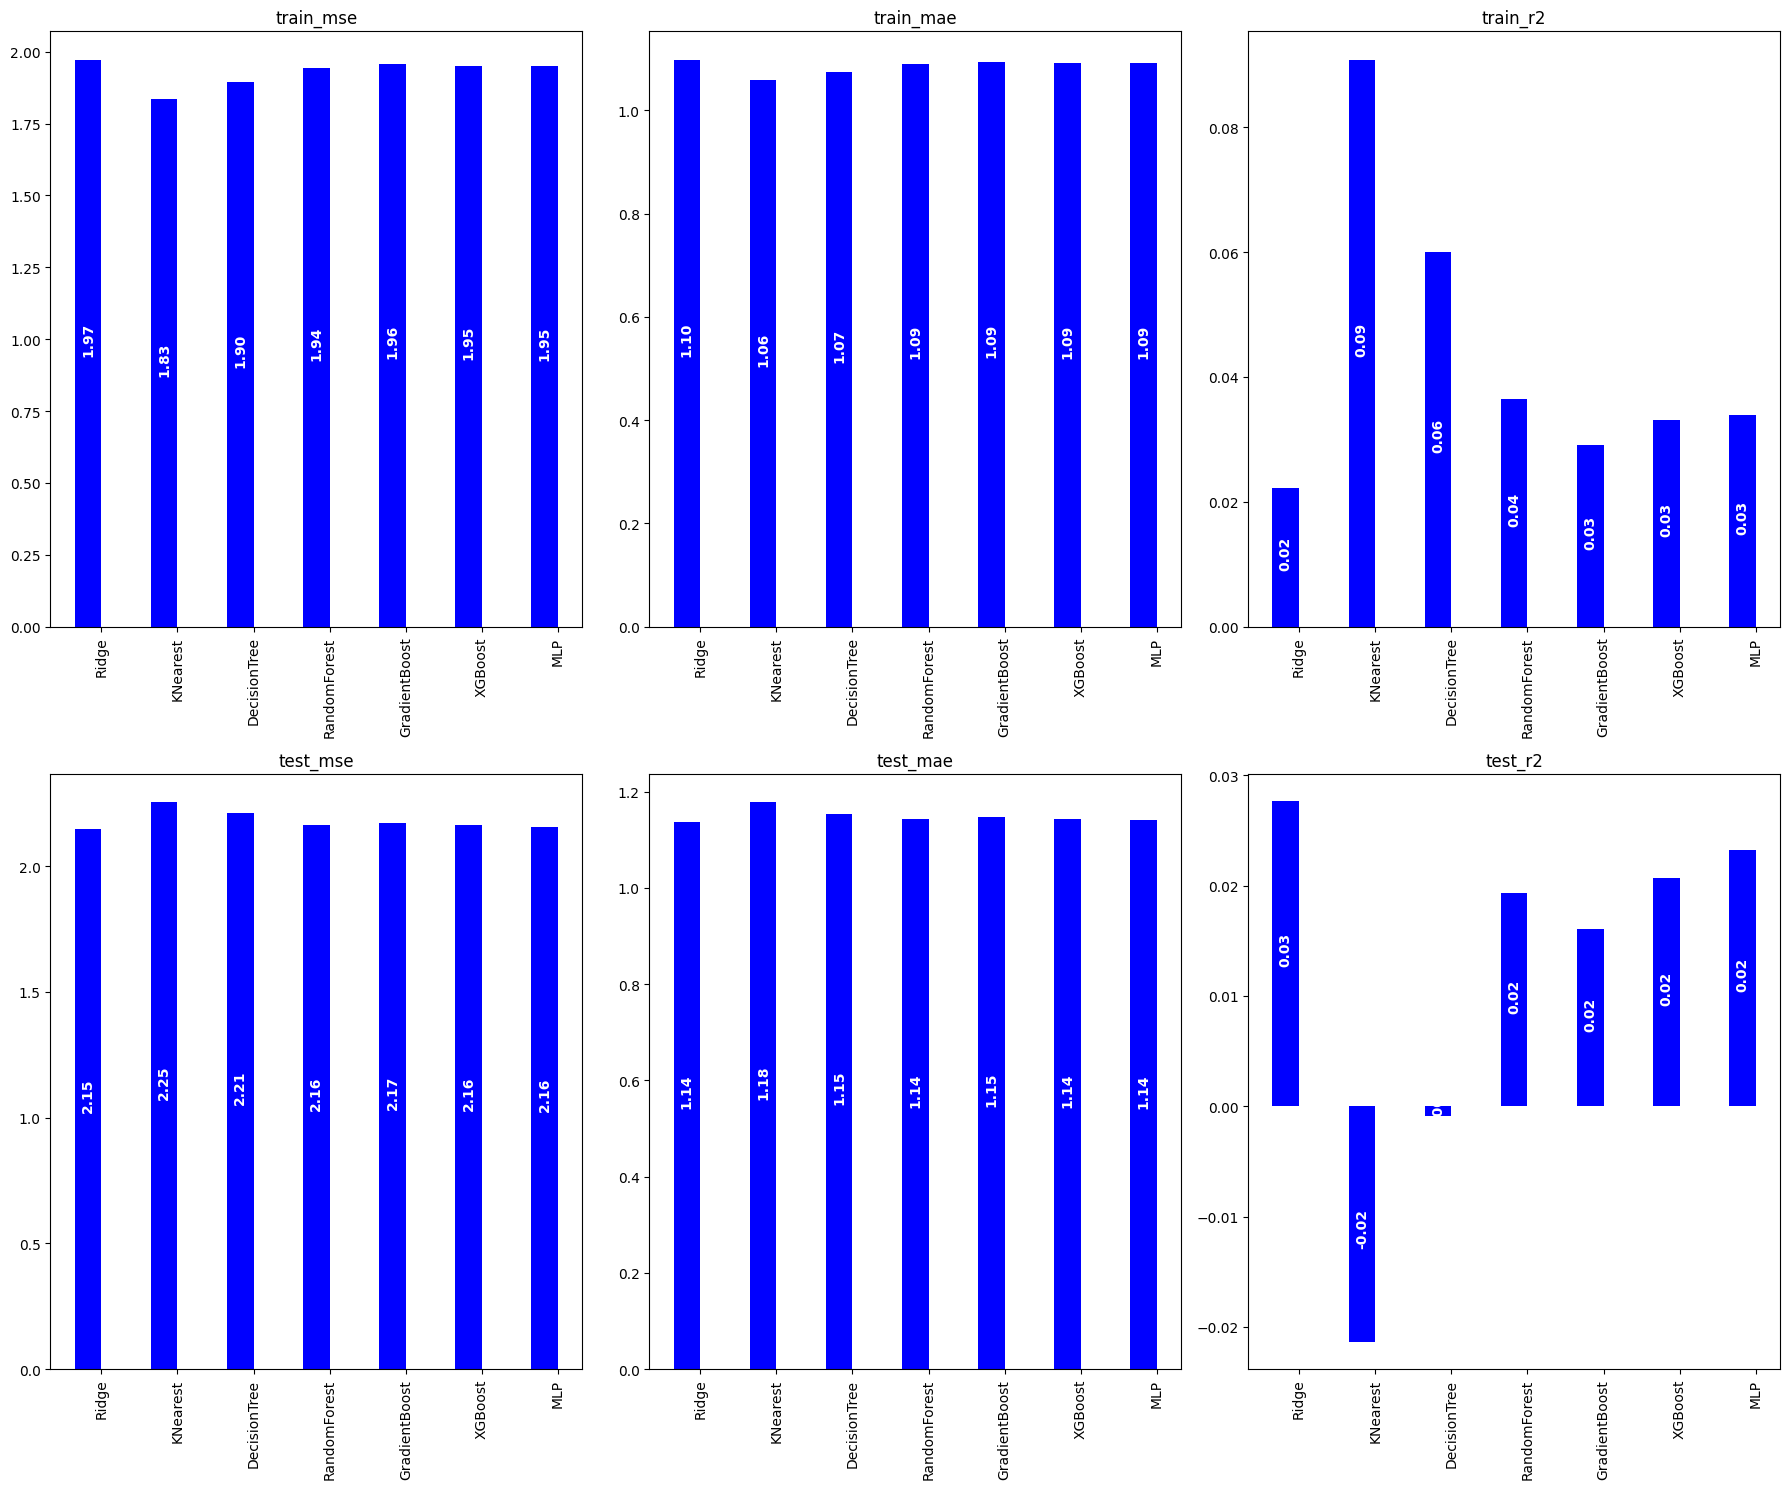

In [54]:
# Results for only Face++ features for predicting the no of donations

donations_models_face = get_the_results(X_train, X_test, param_grid,
                                      numerical_features   = ['beauty'], 
                                      categorical_features = ['gender','smile','emotion','age_group'], 
                                      text_feature         = [],
                                      columns_drop_list    = ['no_of_donations','raised_amount'],
                                      target_list          = ['no_of_donations'])

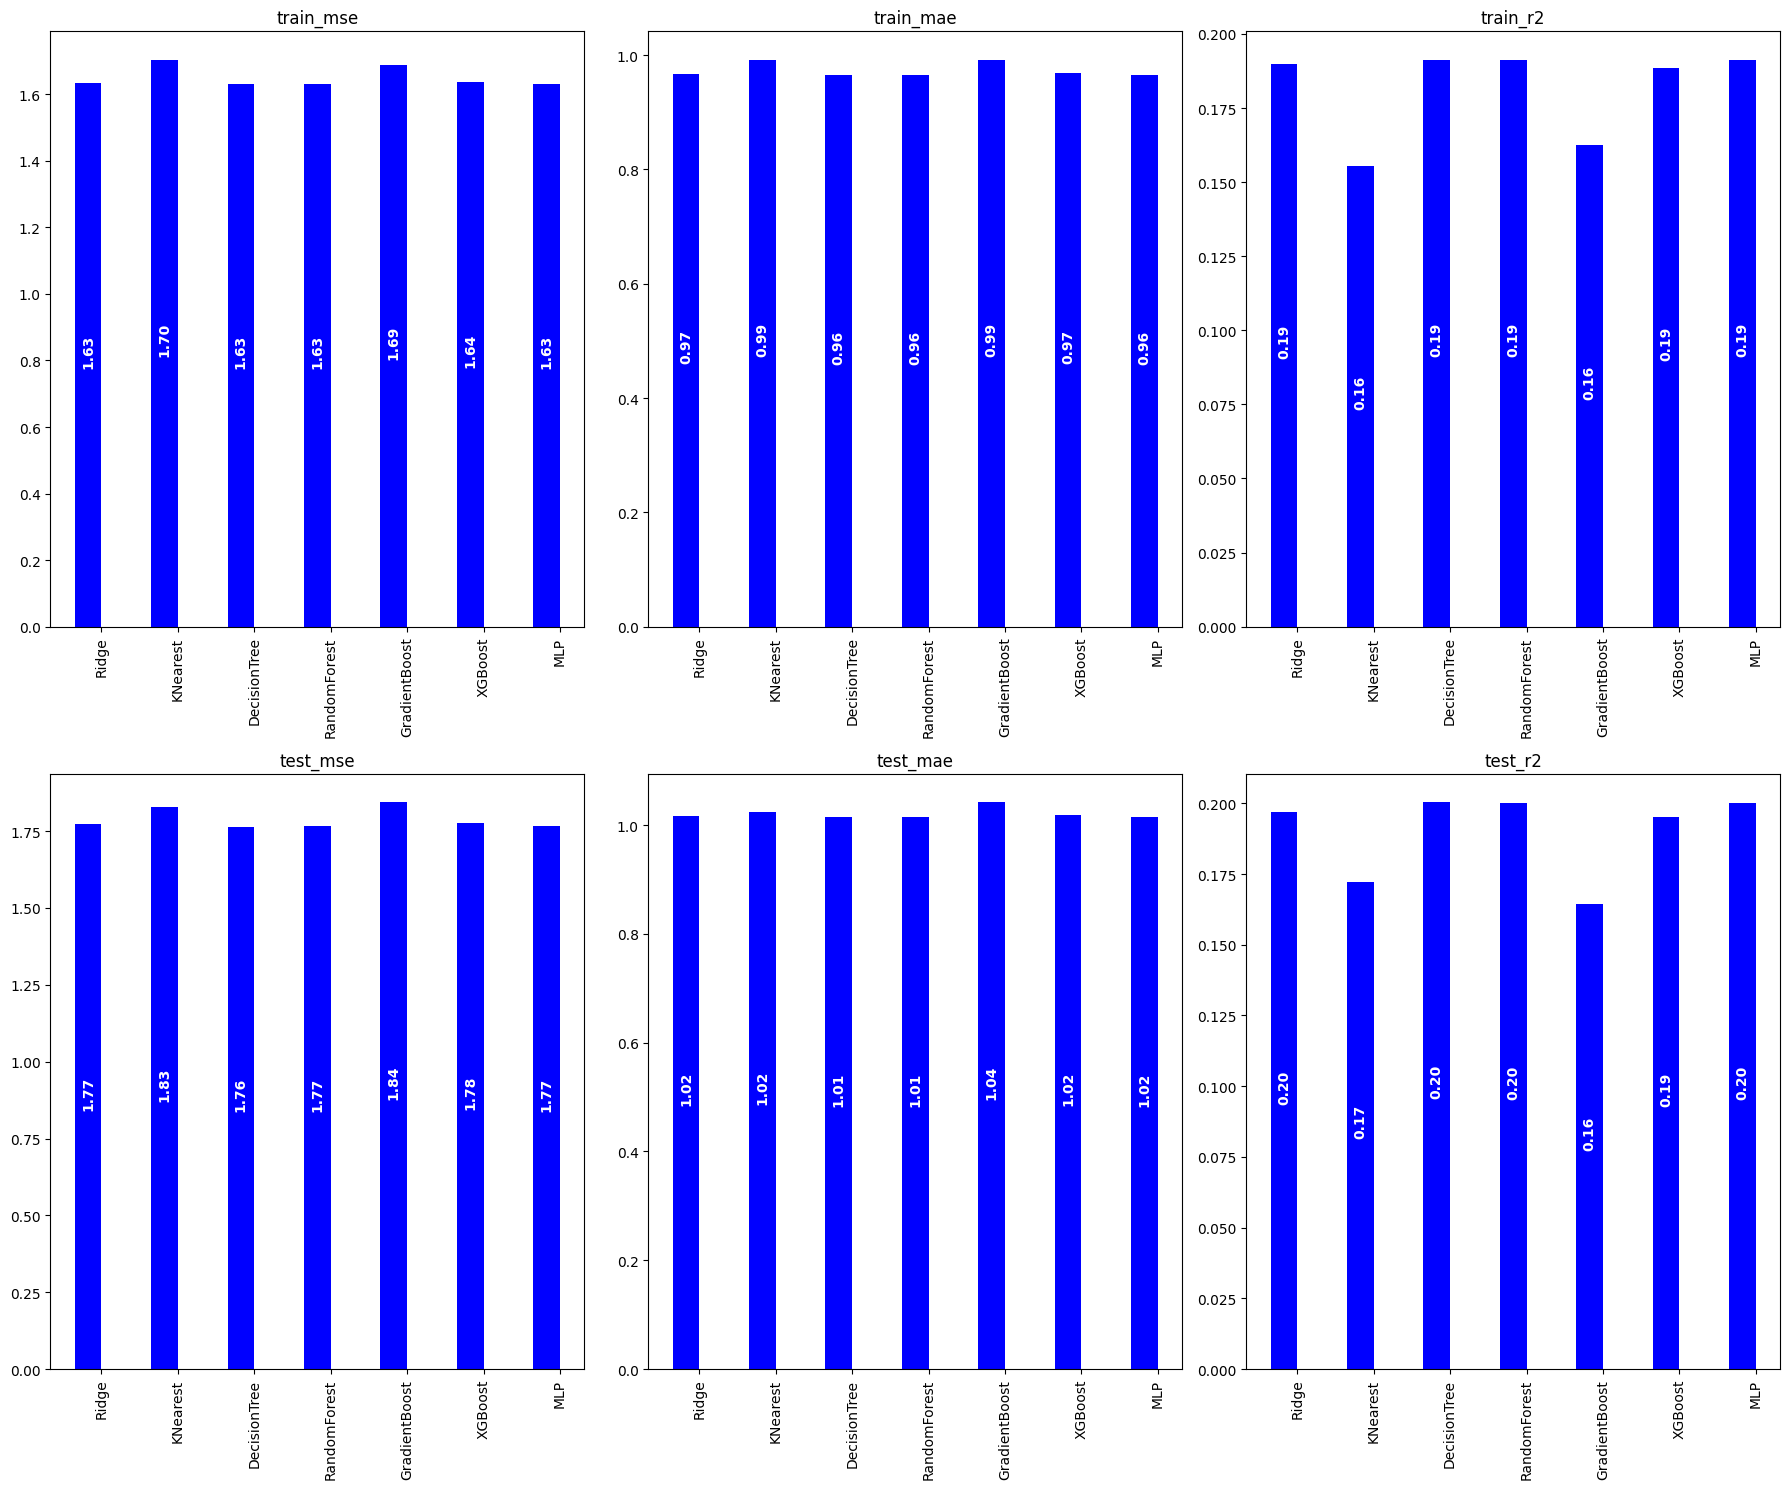

In [55]:
# Results for only urgency feature for predicting the no of donations

donations_models_urgency = get_the_results(X_train, X_test, param_grid,
                                      numerical_features   = [], 
                                      categorical_features = ['urgency'], 
                                      text_feature         = [],
                                      columns_drop_list    = ['no_of_donations','raised_amount'],
                                      target_list          = ['no_of_donations'])

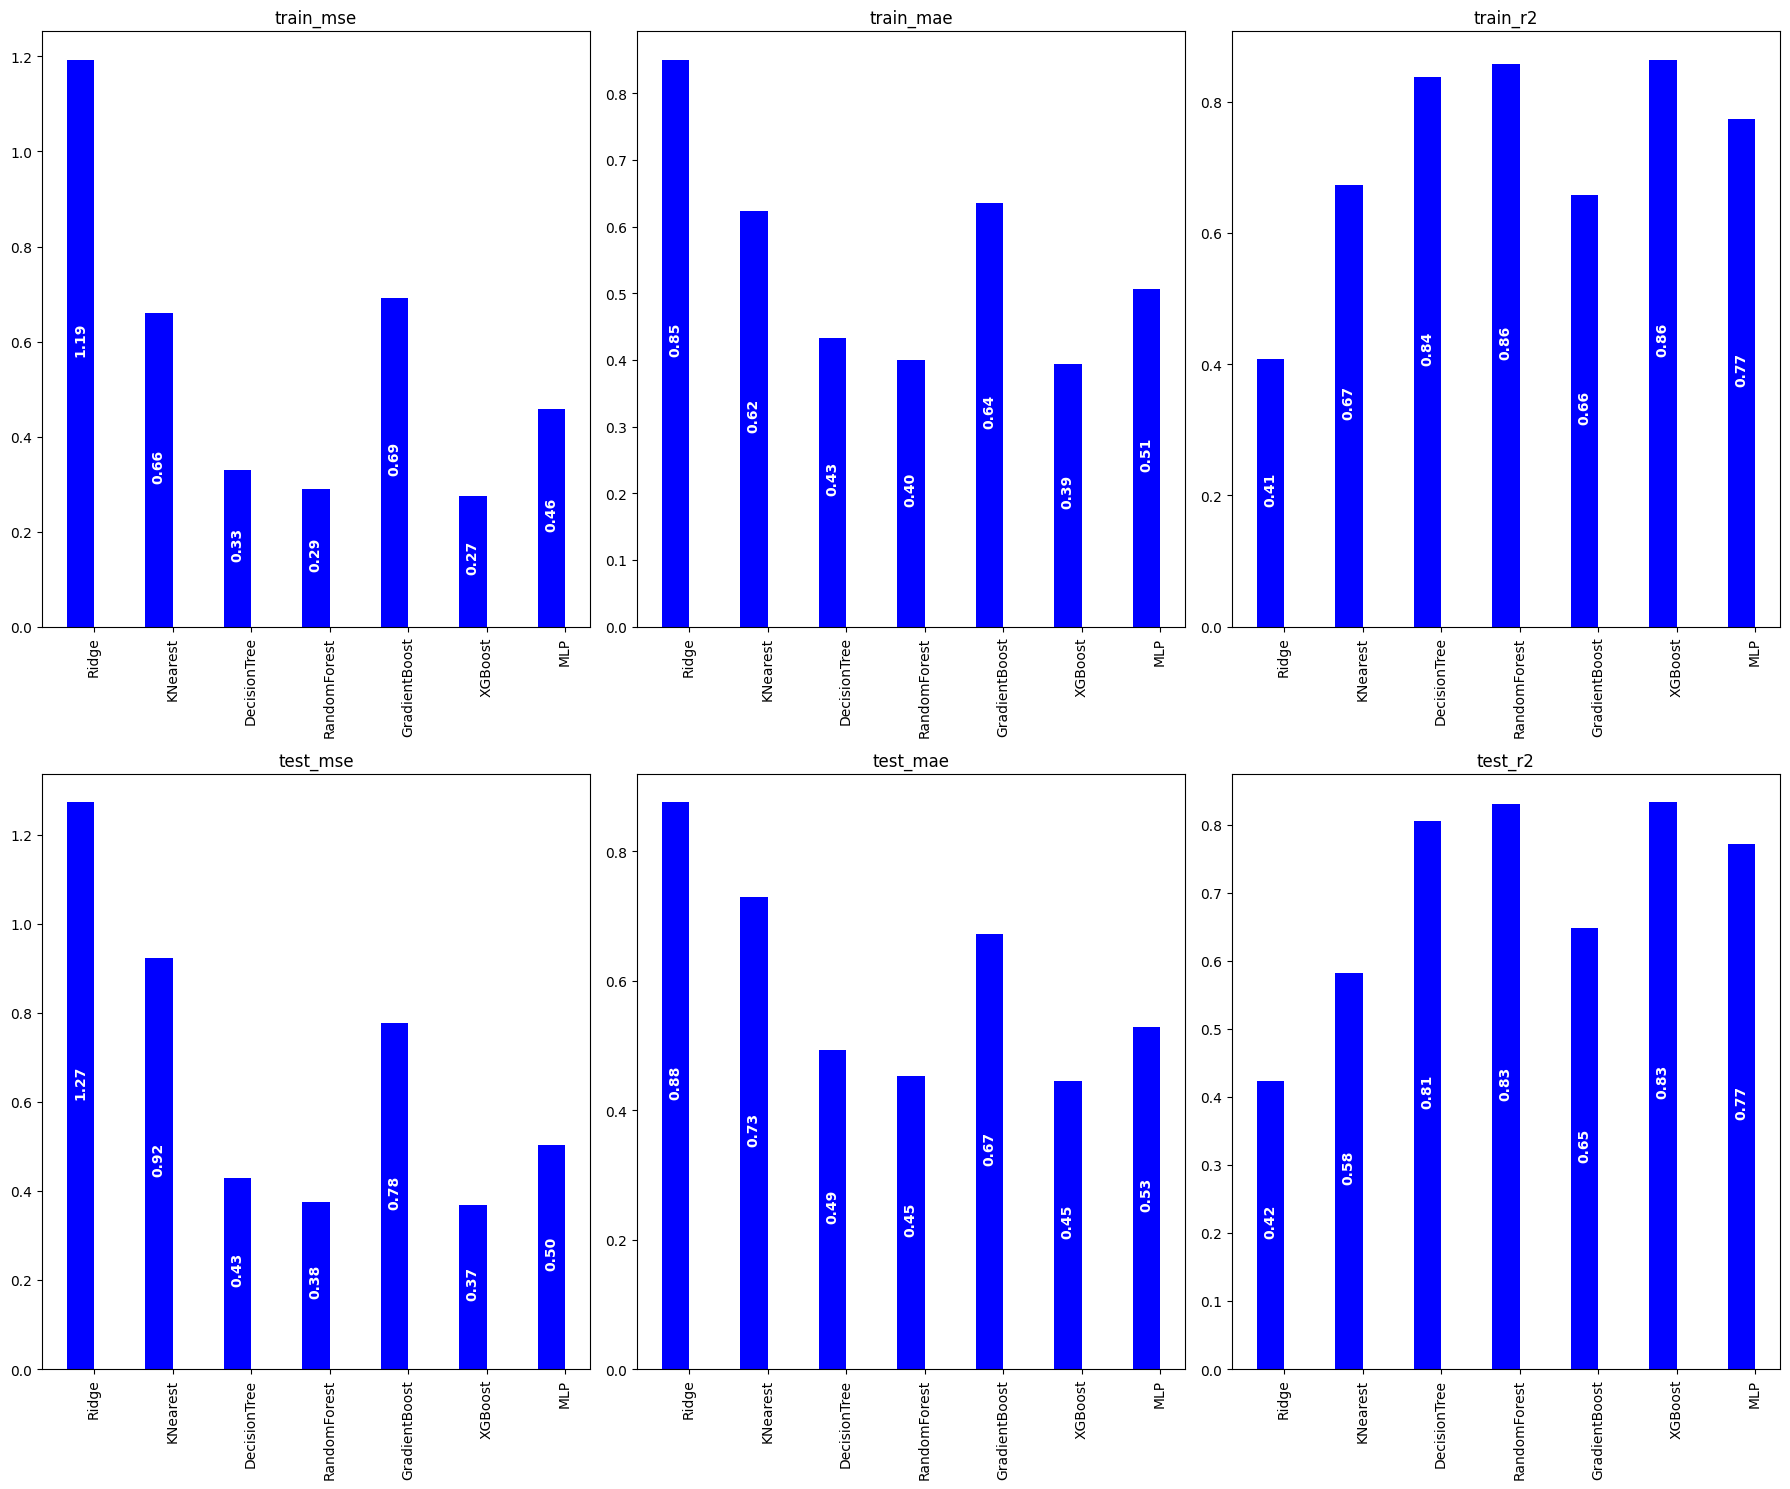

In [56]:
# Results for only numerical features for predicting the no of donations

donations_models_numerical = get_the_results(X_train, X_test, param_grid,
                                      numerical_features   = num_features_donations, 
                                      categorical_features = [], 
                                      text_feature         = [],
                                      columns_drop_list    = ['no_of_donations','raised_amount'],
                                      target_list          = ['no_of_donations'])

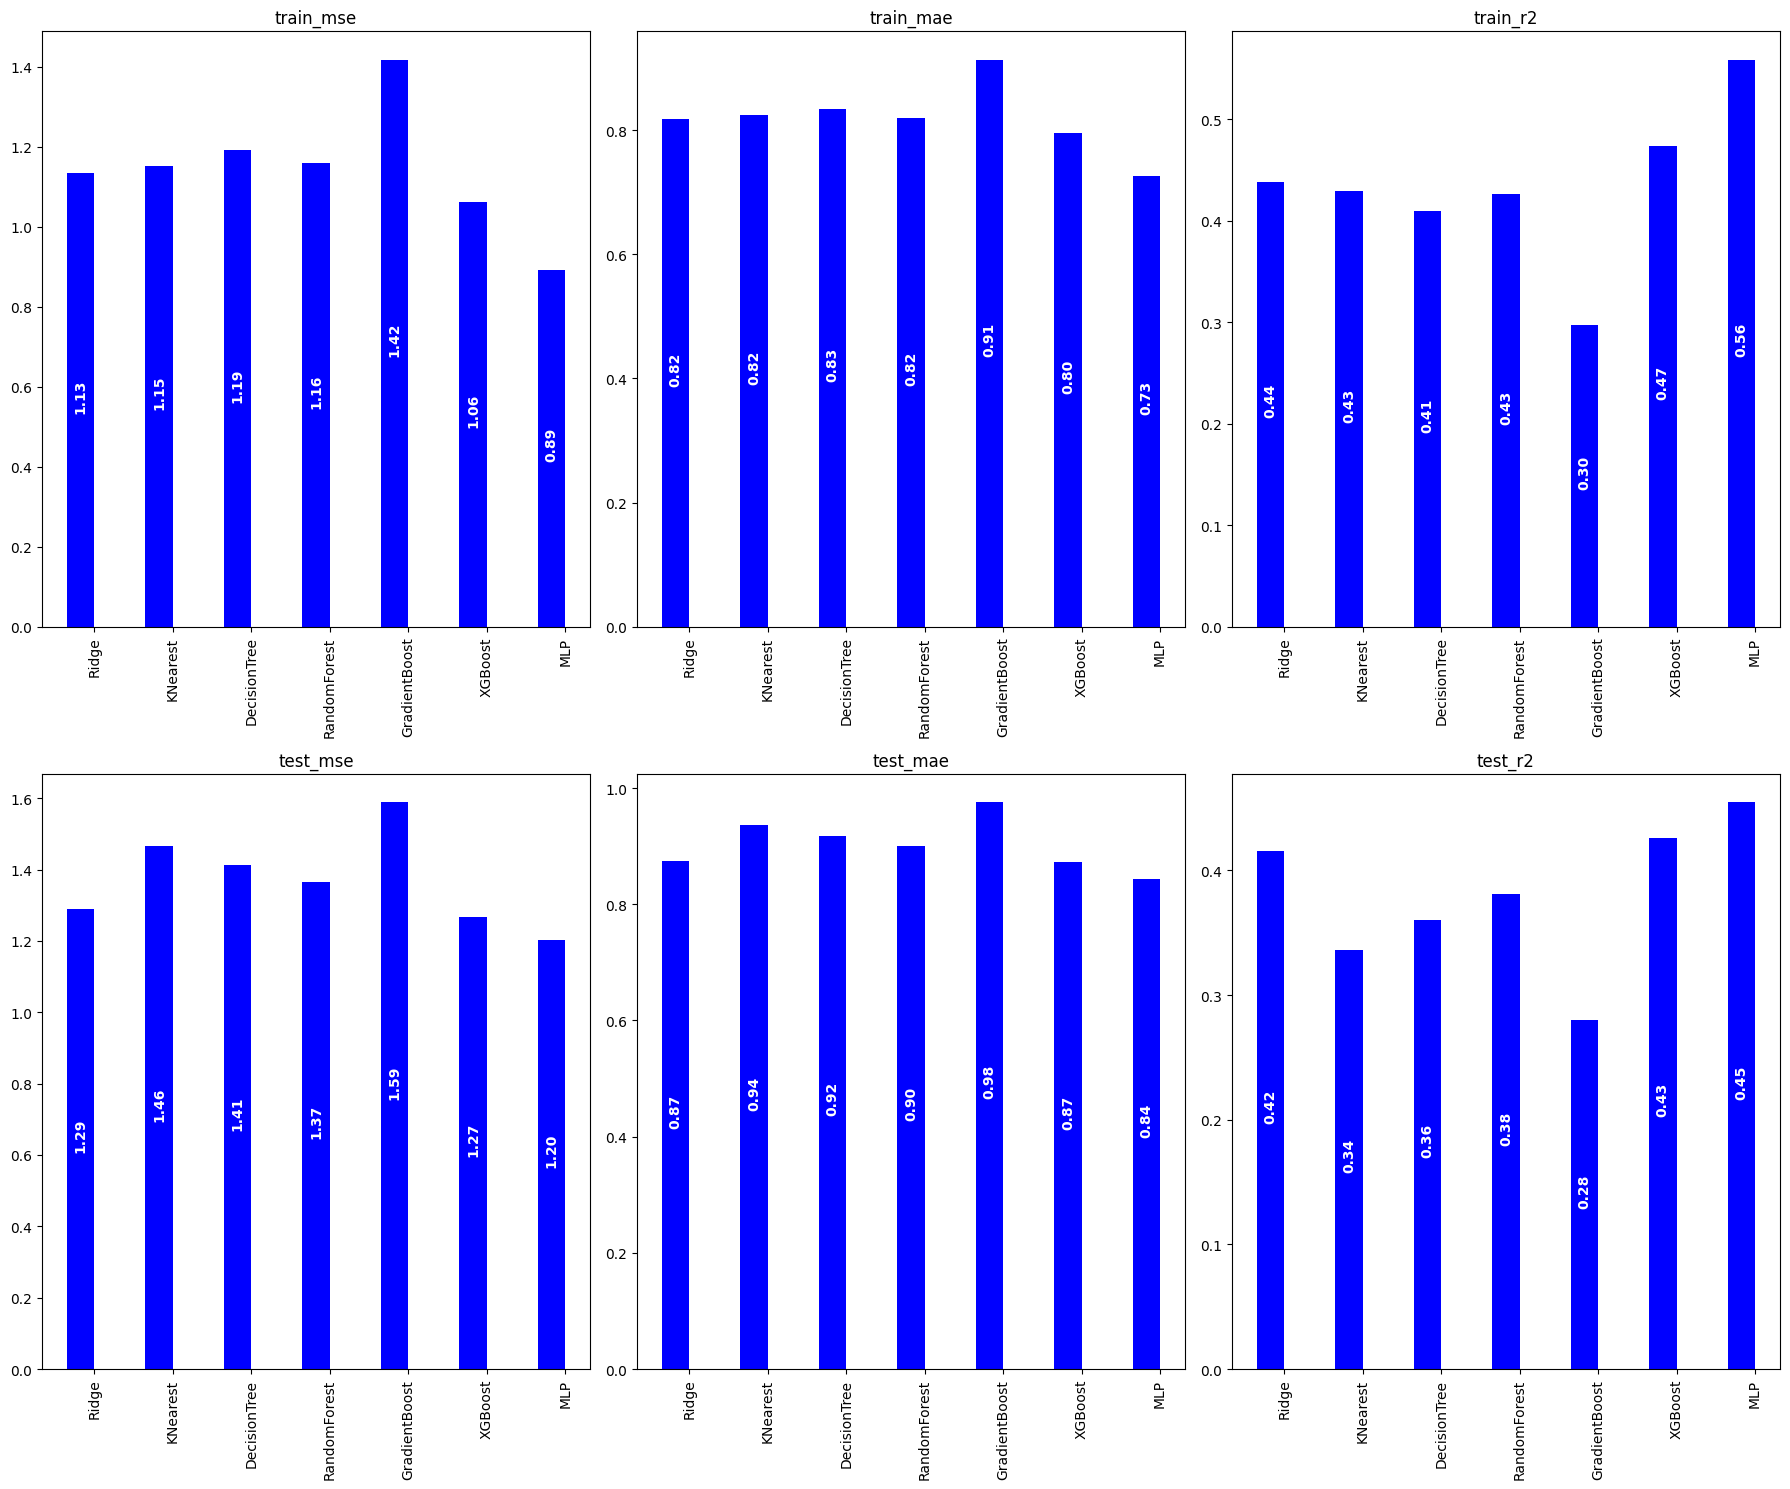

In [57]:
# Results for only categorical features for predicting the no of donations

donations_models_categorical = get_the_results(X_train, X_test, param_grid,
                                      numerical_features   = [], 
                                      categorical_features = cat_features_donations, 
                                      text_feature         = [],
                                      columns_drop_list    = ['no_of_donations','raised_amount'],
                                      target_list          = ['no_of_donations'])

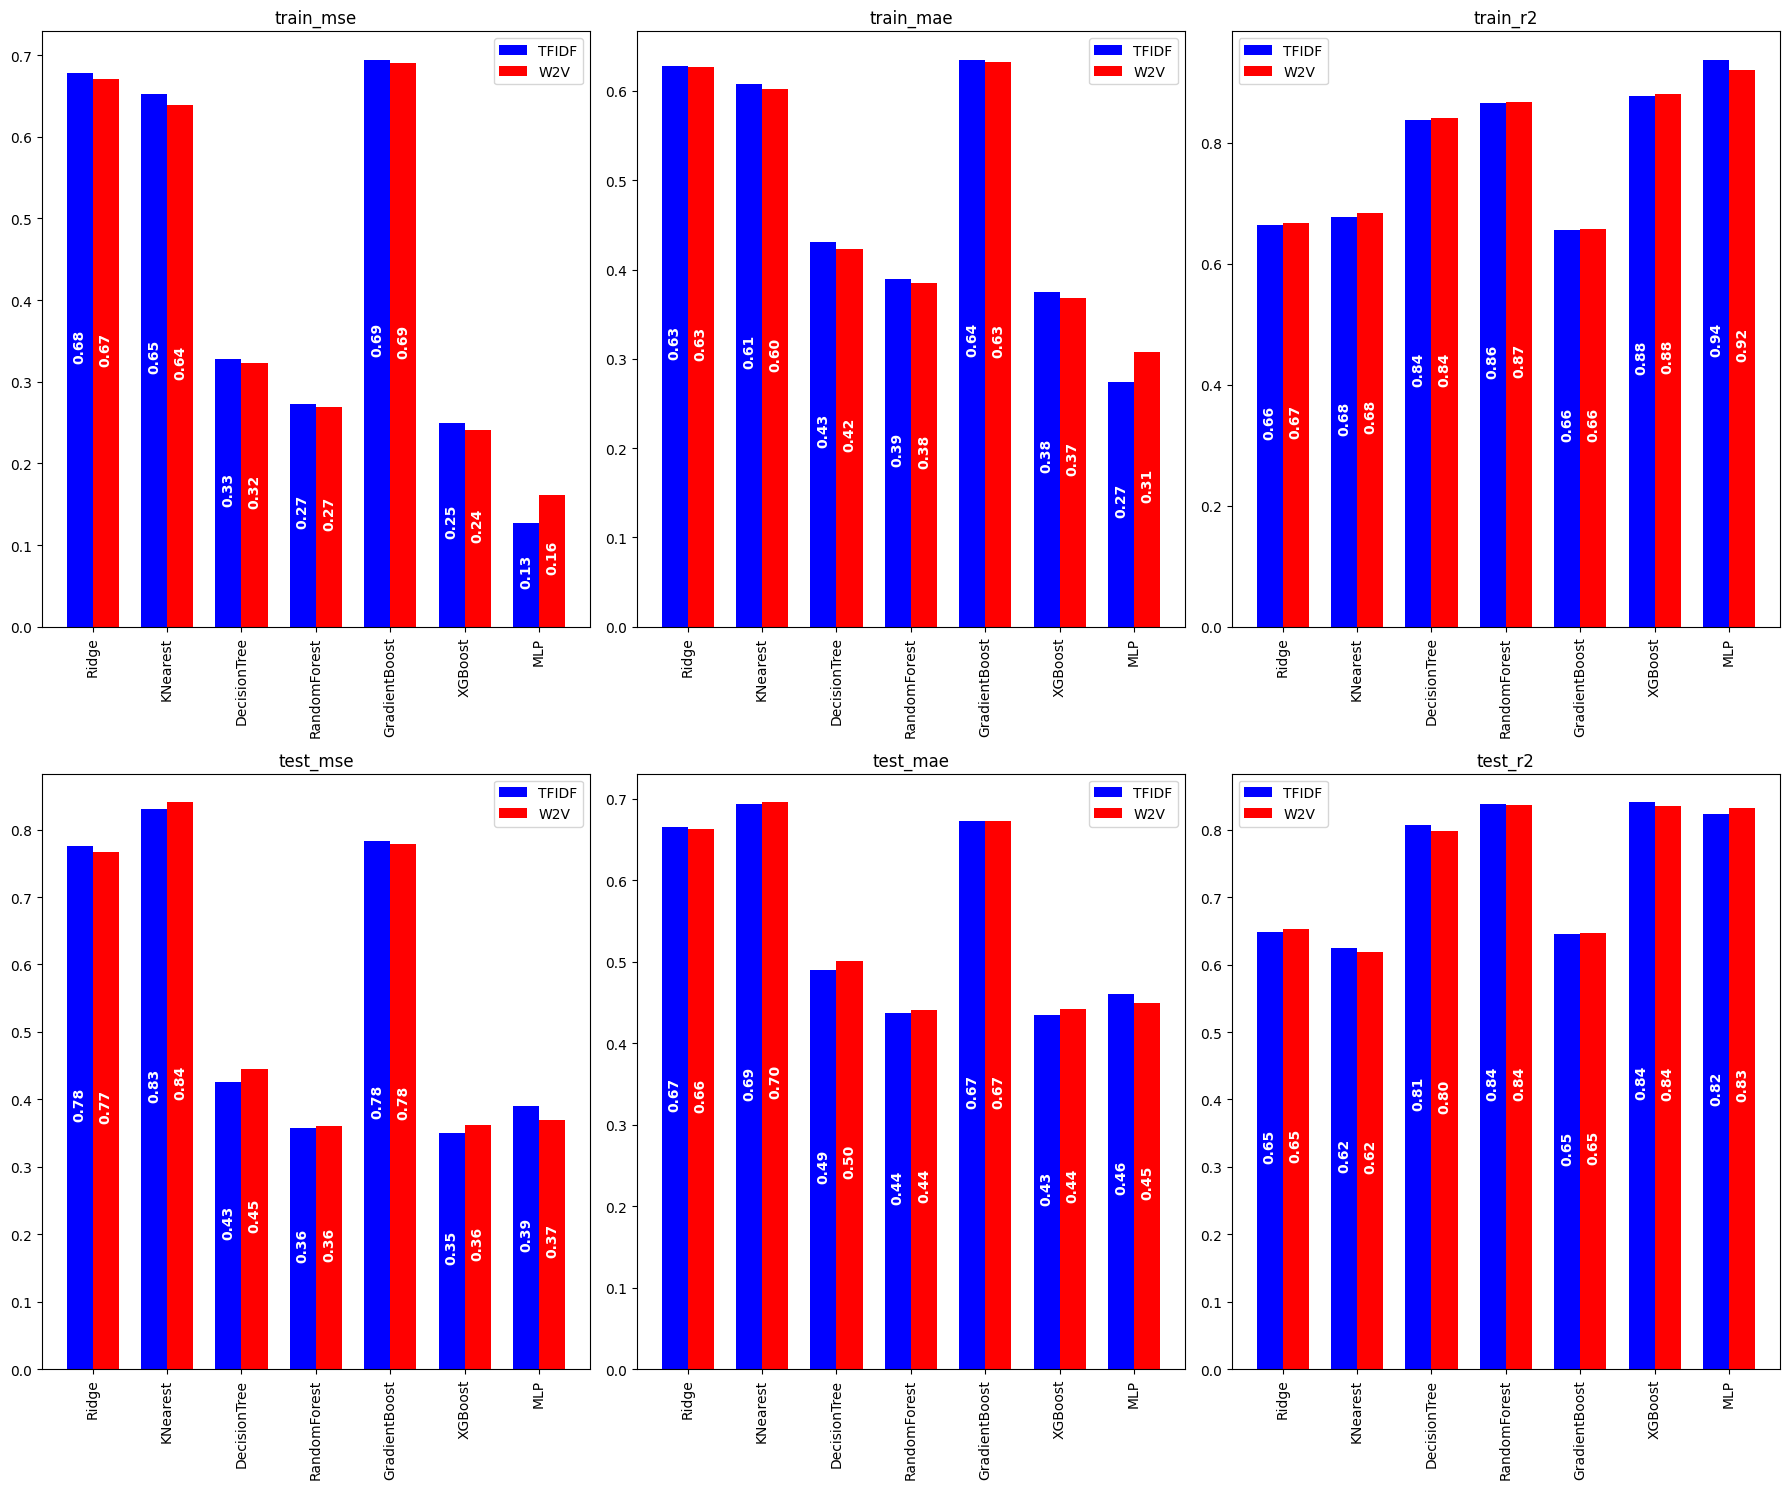

In [58]:
# Results for only all features for predicting the no of donations

donations_models_all = get_the_results(X_train, X_test, param_grid,
                                      numerical_features   = num_features_donations, 
                                      categorical_features = cat_features_donations, 
                                      text_feature         = text_feature,
                                      columns_drop_list    = ['no_of_donations','raised_amount'],
                                      target_list          = ['no_of_donations'])

Considering R2 Score as the selection criteria for choosing the best model,<br> 
* ***Random Forest trained on all the features [text featurization - Word2Vec]***<br> 
* ***MLP trained on all the features [text featurization - TFIDF]***<br>
* ***MLP trained on all the features [text featurization - W2V]***<br>
performed better with ***0.84 R2 score*** on test data. Here, Random Forest regressor with W2V featurization is used for extracting best features and predictions for no of donations.

In [59]:
# Display the top 10 features along with their coefficient scores
print('The top 10 features in predicting the no of donations are:\n')

# Extract the preprocessor and regression steps
preprocessor = donations_models_all['RandomForest_w2v'].named_steps['preprocessor']
regressor    = donations_models_all['RandomForest_w2v'].named_steps['regressor']

# Get feature names and their coefficients
feature_names = preprocessor.get_feature_names_out()
coefficients  = regressor.feature_importances_

# Get the indices of the top 10 coefficients based on absolute values (magnitude)
top_indices = np.argsort(np.abs(coefficients))[::-1][:10]

# Print each top feature with its corresponding signed coefficient score
for i in top_indices:
    print(f"    {feature_names[i]:<40}: {coefficients[i]: .4f}")

The top 10 features in predicting the no of donations are:

    num__goal_amount                        :  0.4992
    num__ratio                              :  0.4745
    text_w2v__live                          :  0.0018
    text_w2v__surgery                       :  0.0017
    text_w2v__hello                         :  0.0016
    text_w2v__contribution                  :  0.0013
    text_w2v__want                          :  0.0011
    text_w2v__place                         :  0.0011
    text_w2v__son                           :  0.0009
    text_w2v__donation                      :  0.0009


1. *num__ratio (0.4906)*: 

    This feature represents the ratio, the proportion of funds raised to the goal amount. Its high importance suggests that  donors are more likely to contribute when they see progress towards a fundraising goal. A higher ratio may inspire         confidence and encourage additional donations.
   
2. *num__goal_amount (0.4831)*: 

   The goal amount itself is crucial in predicting donations. A clear and reasonable fundraising target influences donors' decisions, with a higher or lower goal potentially driving different donor behaviors. This feature reflects the size of the ambition behind the campaign.

3. *text_w2v__live (0.0037)*: 
   
   The presence of the word *Live* in the campaign's text likely indicates real-time or ongoing relevance, which could evoke urgency in potential donors. Words like *Live* suggest that the campaign is active and happening now, motivating donations from those who feel compelled to act immediately.

4. *text_w2v__donation (0.0023)*: 
   
   Including the word *donation* in the text signals the primary goal of the campaign: receiving donations. This direct approach in the campaign's messaging is important for engagement and for clarifying the call-to-action to donors.

5. *text_w2v__medical (0.0023)*: 
   
   The word *medical* is strongly associated with urgent, life-saving causes. Campaigns involving medical needs tend to garner more attention and donations because donors often feel a stronger emotional response when they know the funds are being used for critical health-related issues.

6. *num__beauty (0.0014)*: 
   
   This feature could be related to an attribute like the visual appeal of the campaign’s media (e.g., attractive images or design). A higher *beauty* score may correlate with campaigns that are visually compelling, potentially increasing their ability to engage donors.

7. *text_w2v__please (0.0014)*: 
   
   The word *Please* in the campaign's text is associated with politeness and humility, which can increase a donor's willingness to give. It is subtle but important element of persuasive communication, showing the campaign’s respect and appeal for support.

8. *text_w2v__currently (0.0012)*: 
   
   The word *currently* indicates a sense of urgency, as it implies the need for immediate attention. Campaigns that emphasize the current moment or immediate needs are more likely to trigger donors' desire to act quickly.

9. *cat__category_emergency-fundraiser (0.0012)*: 
   
   Categorizing a campaign as an *emergency fundraiser* has significant predictive power, suggesting that emergency situations prompt faster and more generous donations. People tend to respond quickly to emergencies, often feeling an immediate sense of duty to help.

10. *text_w2v__since (0.0012)*: 
    
    The word *since* could relate to the timeline or history of the campaign, helping to provide context for the story being told. When campaigns explain their progress or long-term need, donors may connect more deeply with the cause, enhancing their willingness to contribute.


**Summary**

The most dominant predictors of the number of donations are numeric features like the *goal amount* and the *ratio* of the raised amount to the goal. These features reflect how much progress a campaign has made and how close it is to its target, motivating more donors to contribute. Text-based features like the words *live*, *donation*, *medical*, and *please* have a strong influence, reinforcing the campaign’s urgency, emotional appeal, and the need for support. Campaign category, particularly *emergency fundraisers*, also plays a significant role in driving higher numbers of donations due to the urgency associated with such causes. The visual appeal of the campaign (*beauty*) and the language used in the description further enhance donor engagement, though their influence is somewhat less significant than the primary features like the *goal amount* and the *ratio*.

***Modelling for predicting the raised amount***

In [60]:
num_features_raised       = X_train.drop(['raised_amount'],
                                         axis=1).select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features_raised       = [i for i in X_train.select_dtypes(include=['object']).columns.tolist()
                                       if i != 'text']
text_feature              = 'text'

print('The numerical features are:')
for i in num_features_raised:
    print('   ' + i)
print('')    
print('The categorical features are:')
for i in cat_features_raised:
    print('   ' + i)
print('')    
print('The text features are:')
print('   ' + text_feature)

The numerical features are:
   goal_amount
   no_of_donations
   duration_days
   beauty
   ratio
   word_len

The categorical features are:
   category
   state
   gender
   smile
   emotion
   age_group
   urgency

The text features are:
   text


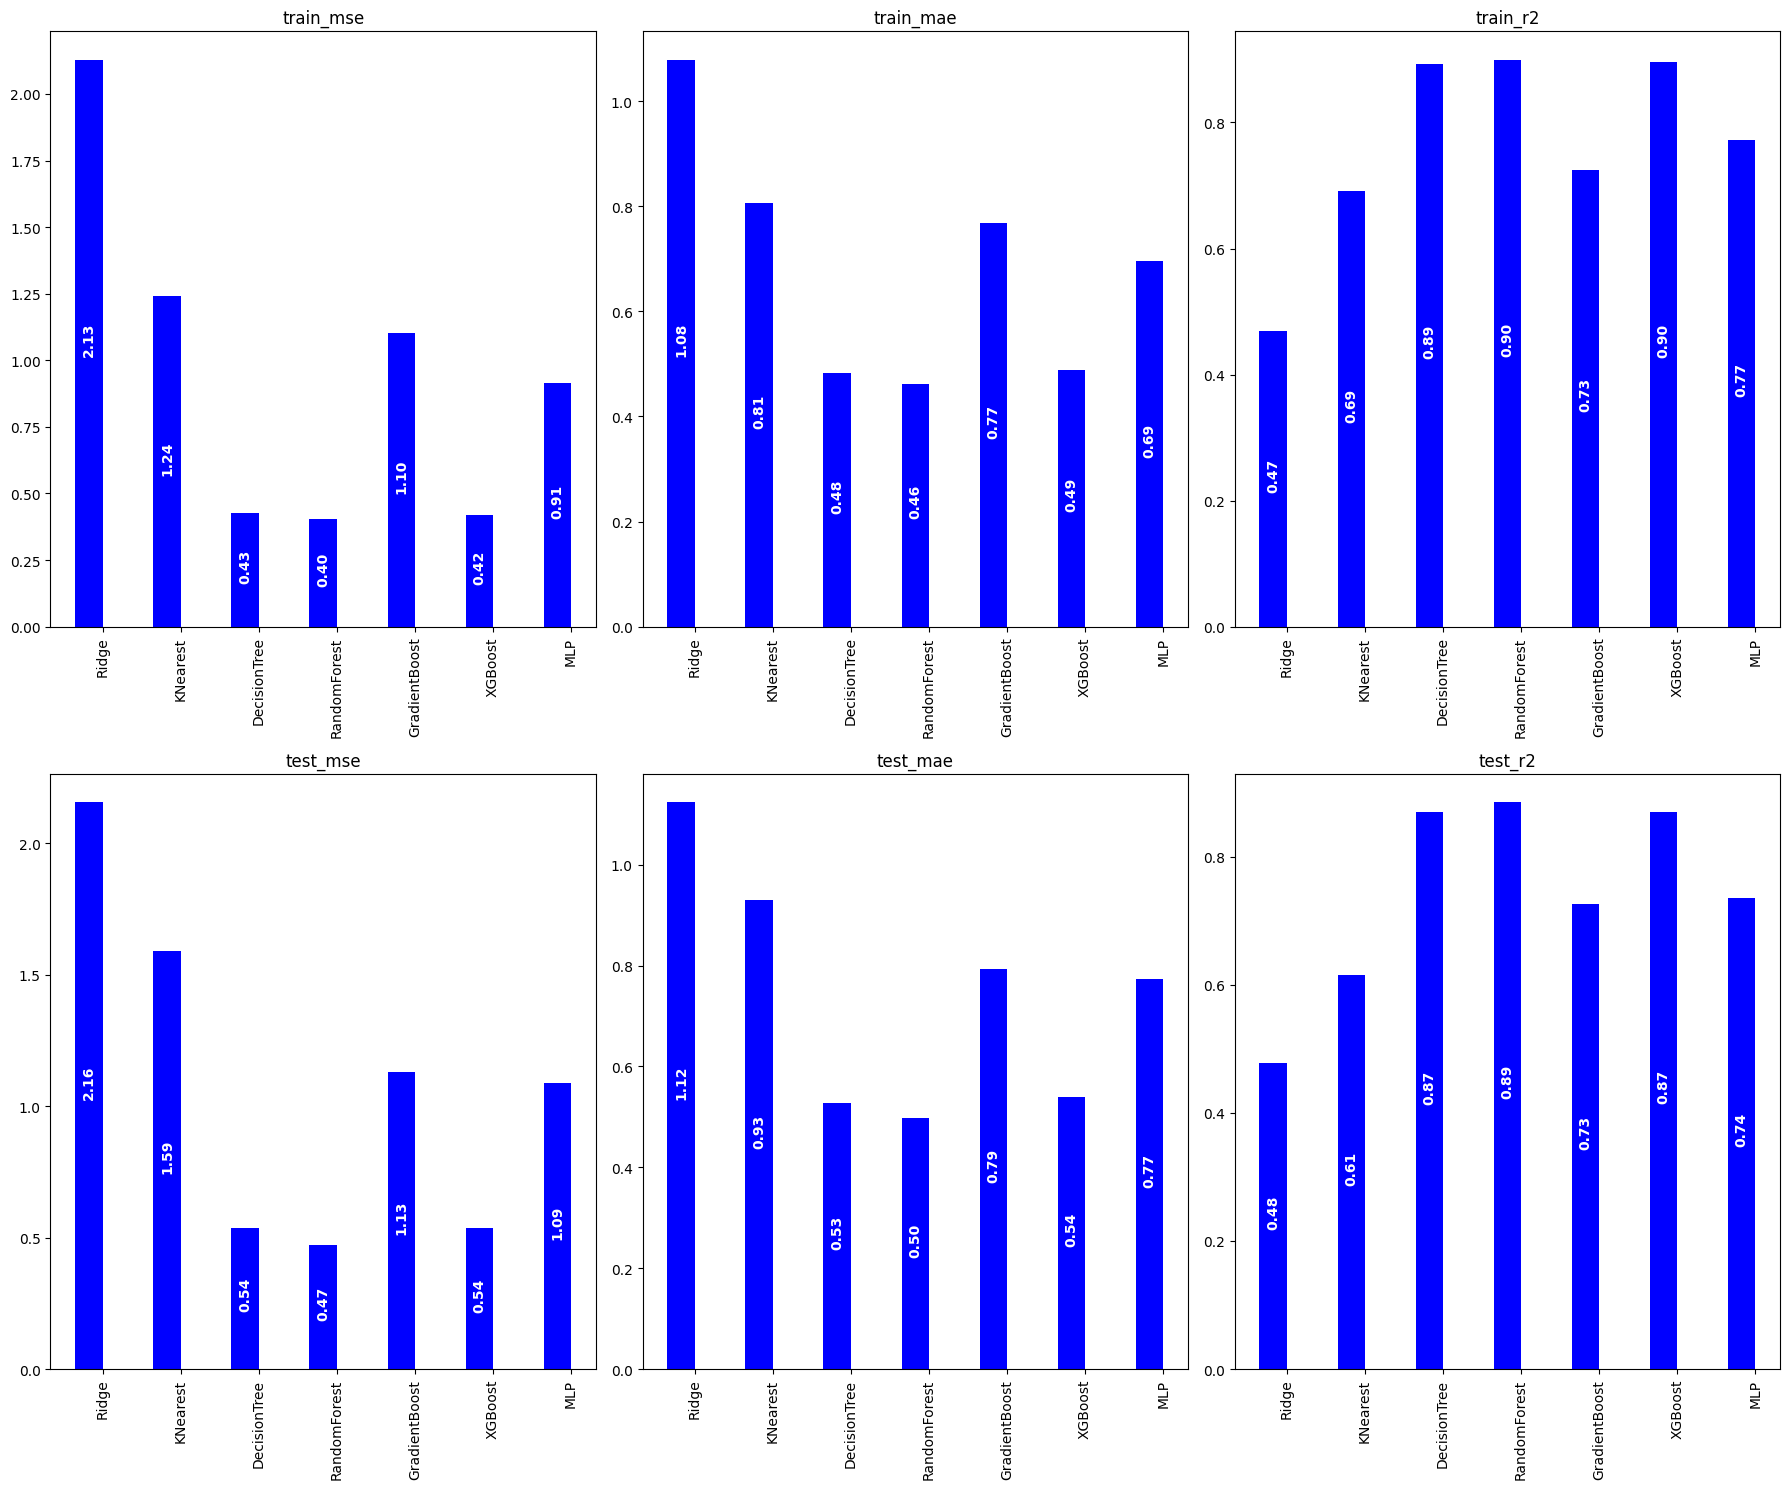

In [69]:
# Results for only basic feature for predicting the raised amount

raised_models_basic = get_the_results(X_train, X_test, param_grid, 
                                      numerical_features   = ['goal_amount','no_of_donations','duration_days'], 
                                      categorical_features = ['category','state'], 
                                      text_feature         = [],
                                      columns_drop_list    = ['raised_amount'],
                                      target_list          = ['raised_amount'])

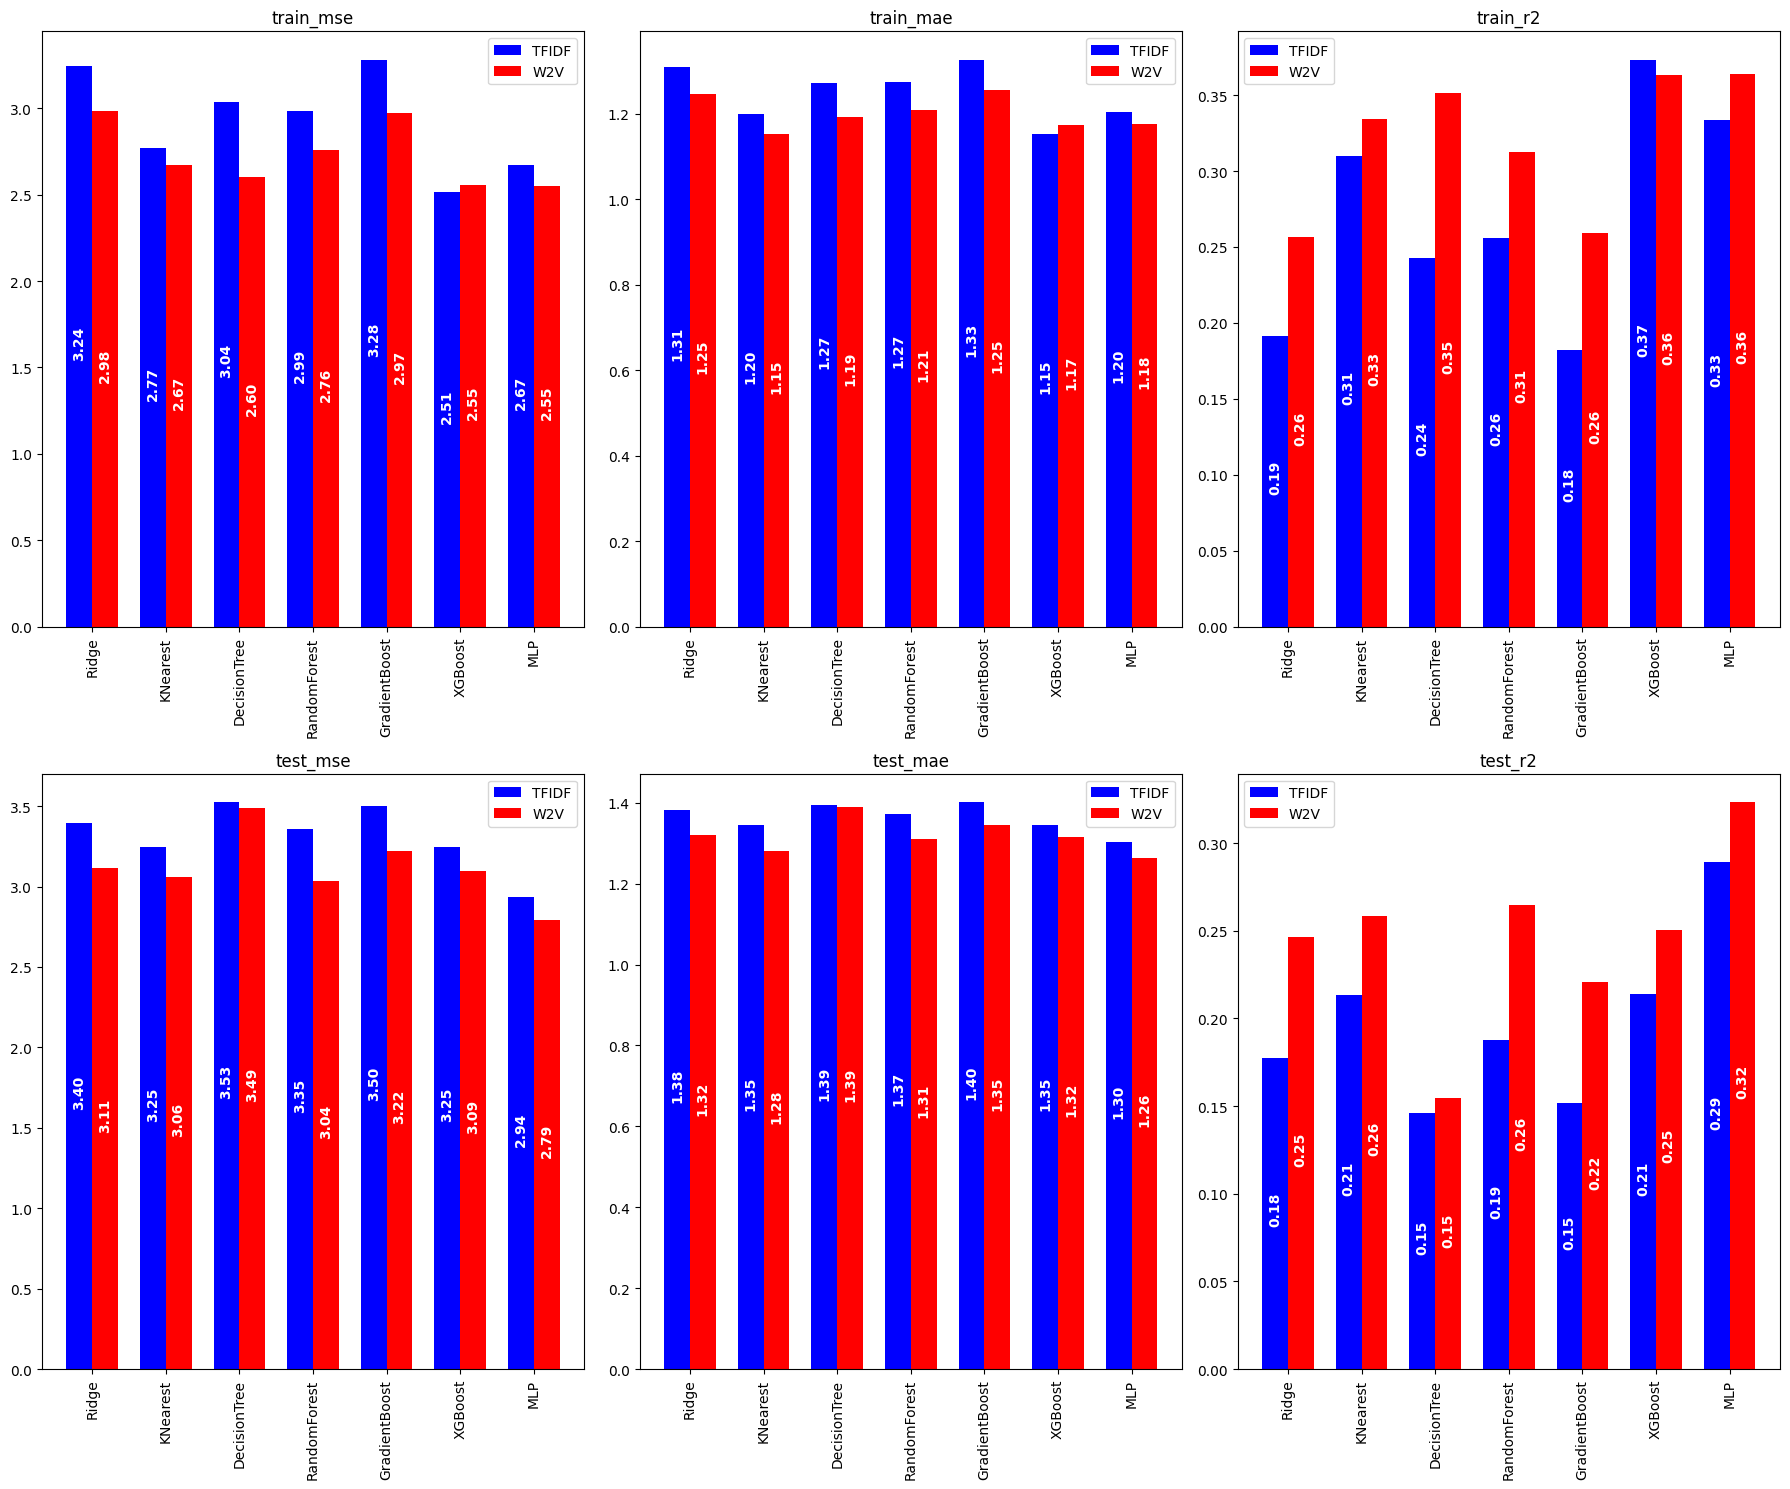

In [62]:
# Results for only text feature for predicting the raised amount

raised_models_text = get_the_results(X_train, X_test, param_grid, 
                                      numerical_features   = [], 
                                      categorical_features = [], 
                                      text_feature         = text_feature,
                                      columns_drop_list    = ['raised_amount'],
                                      target_list          = ['raised_amount'])

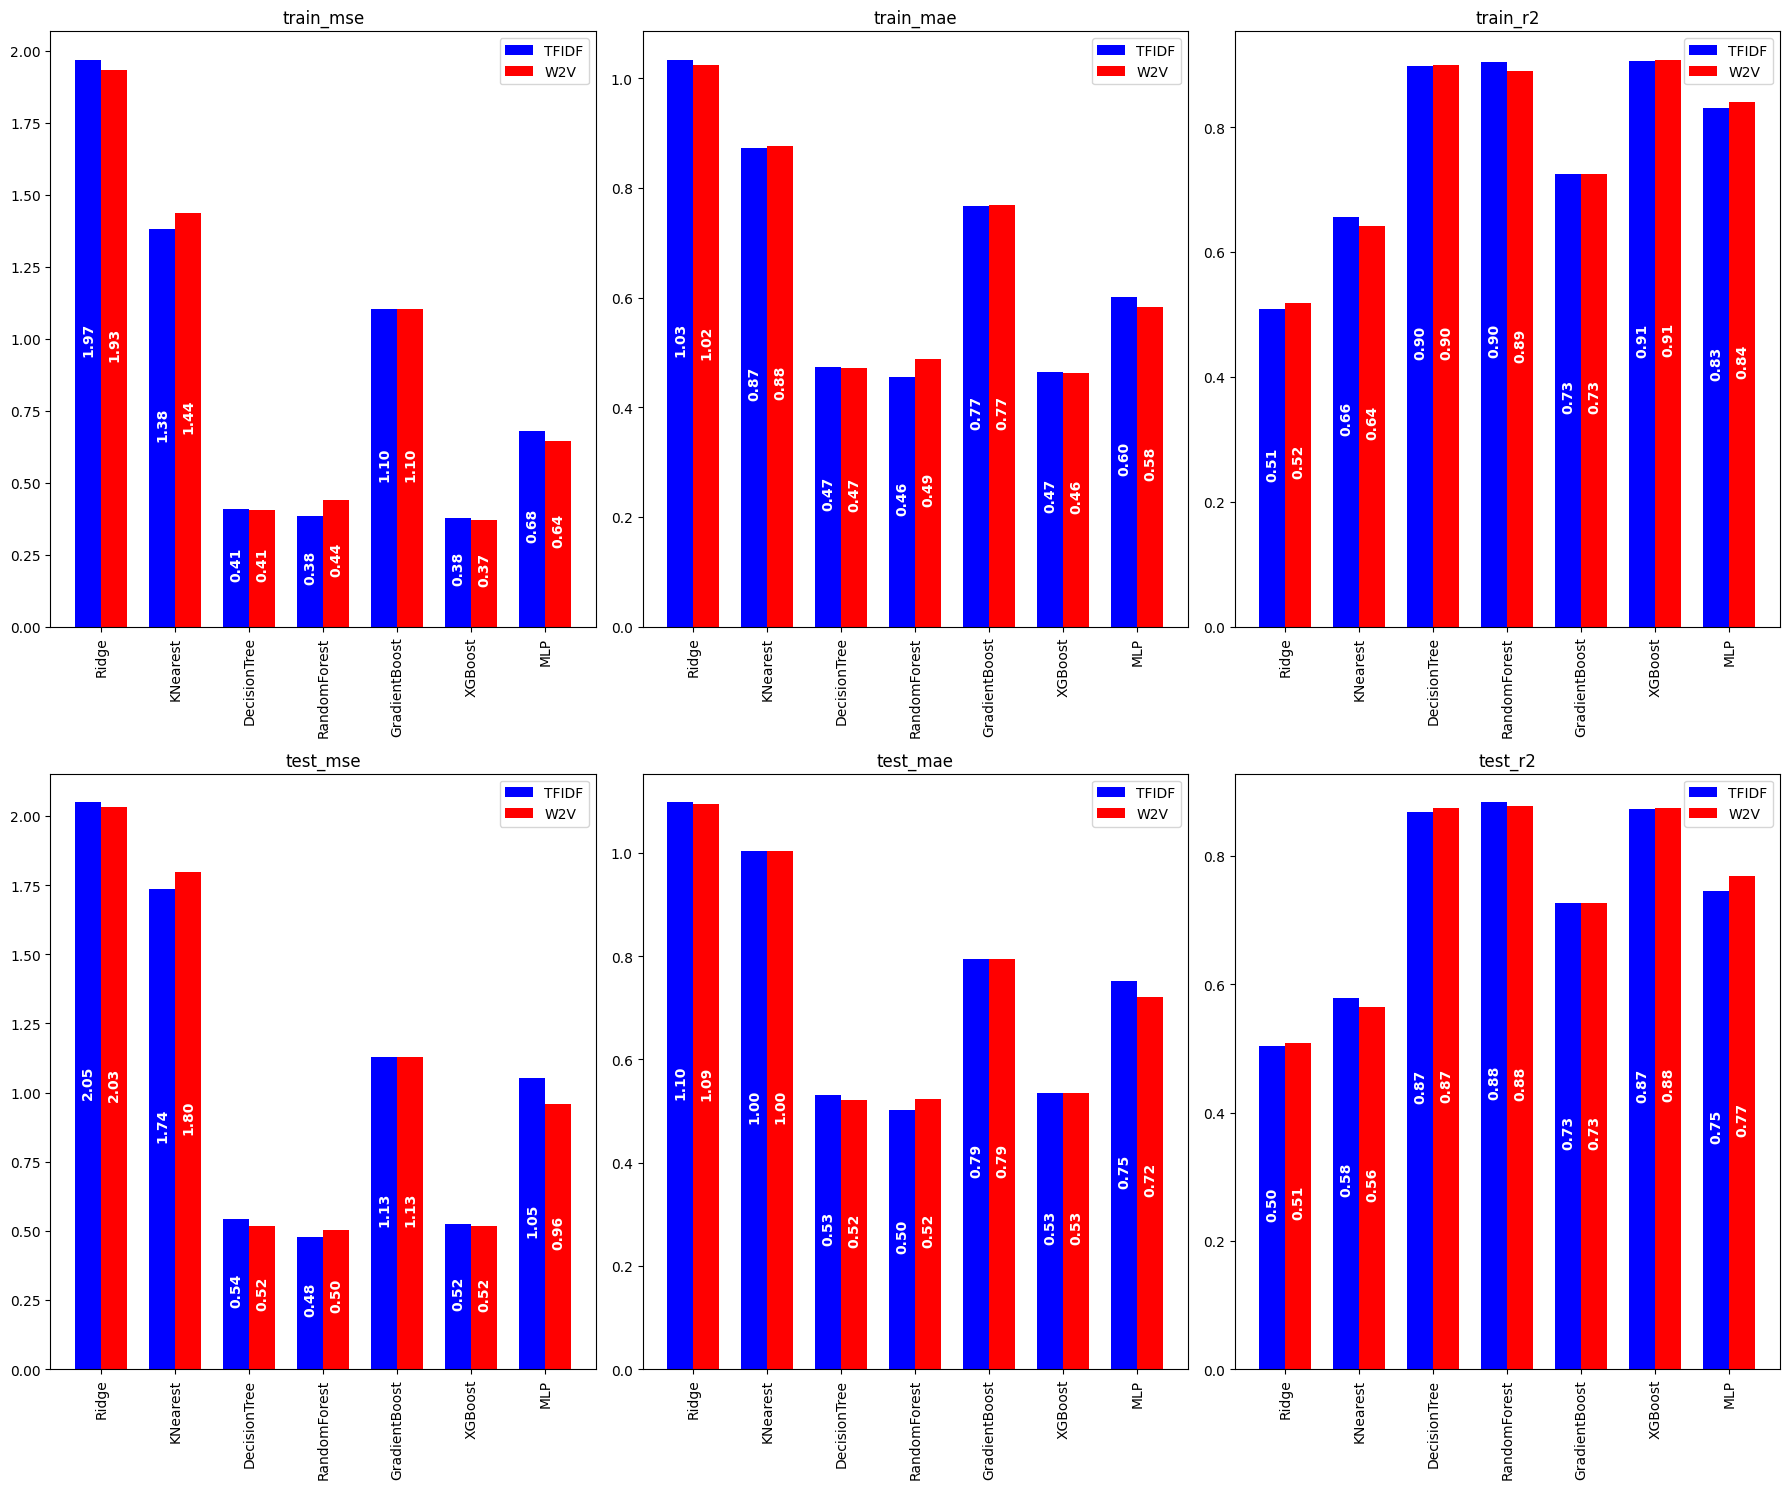

In [70]:
# Results for only basic+text feature for predicting the raised amount

raised_models_basictext = get_the_results(X_train, X_test, param_grid, 
                                      numerical_features   = ['goal_amount','no_of_donations','duration_days'], 
                                      categorical_features = ['category','state'], 
                                      text_feature         = text_feature,
                                      columns_drop_list    = ['raised_amount'],
                                      target_list          = ['raised_amount'])

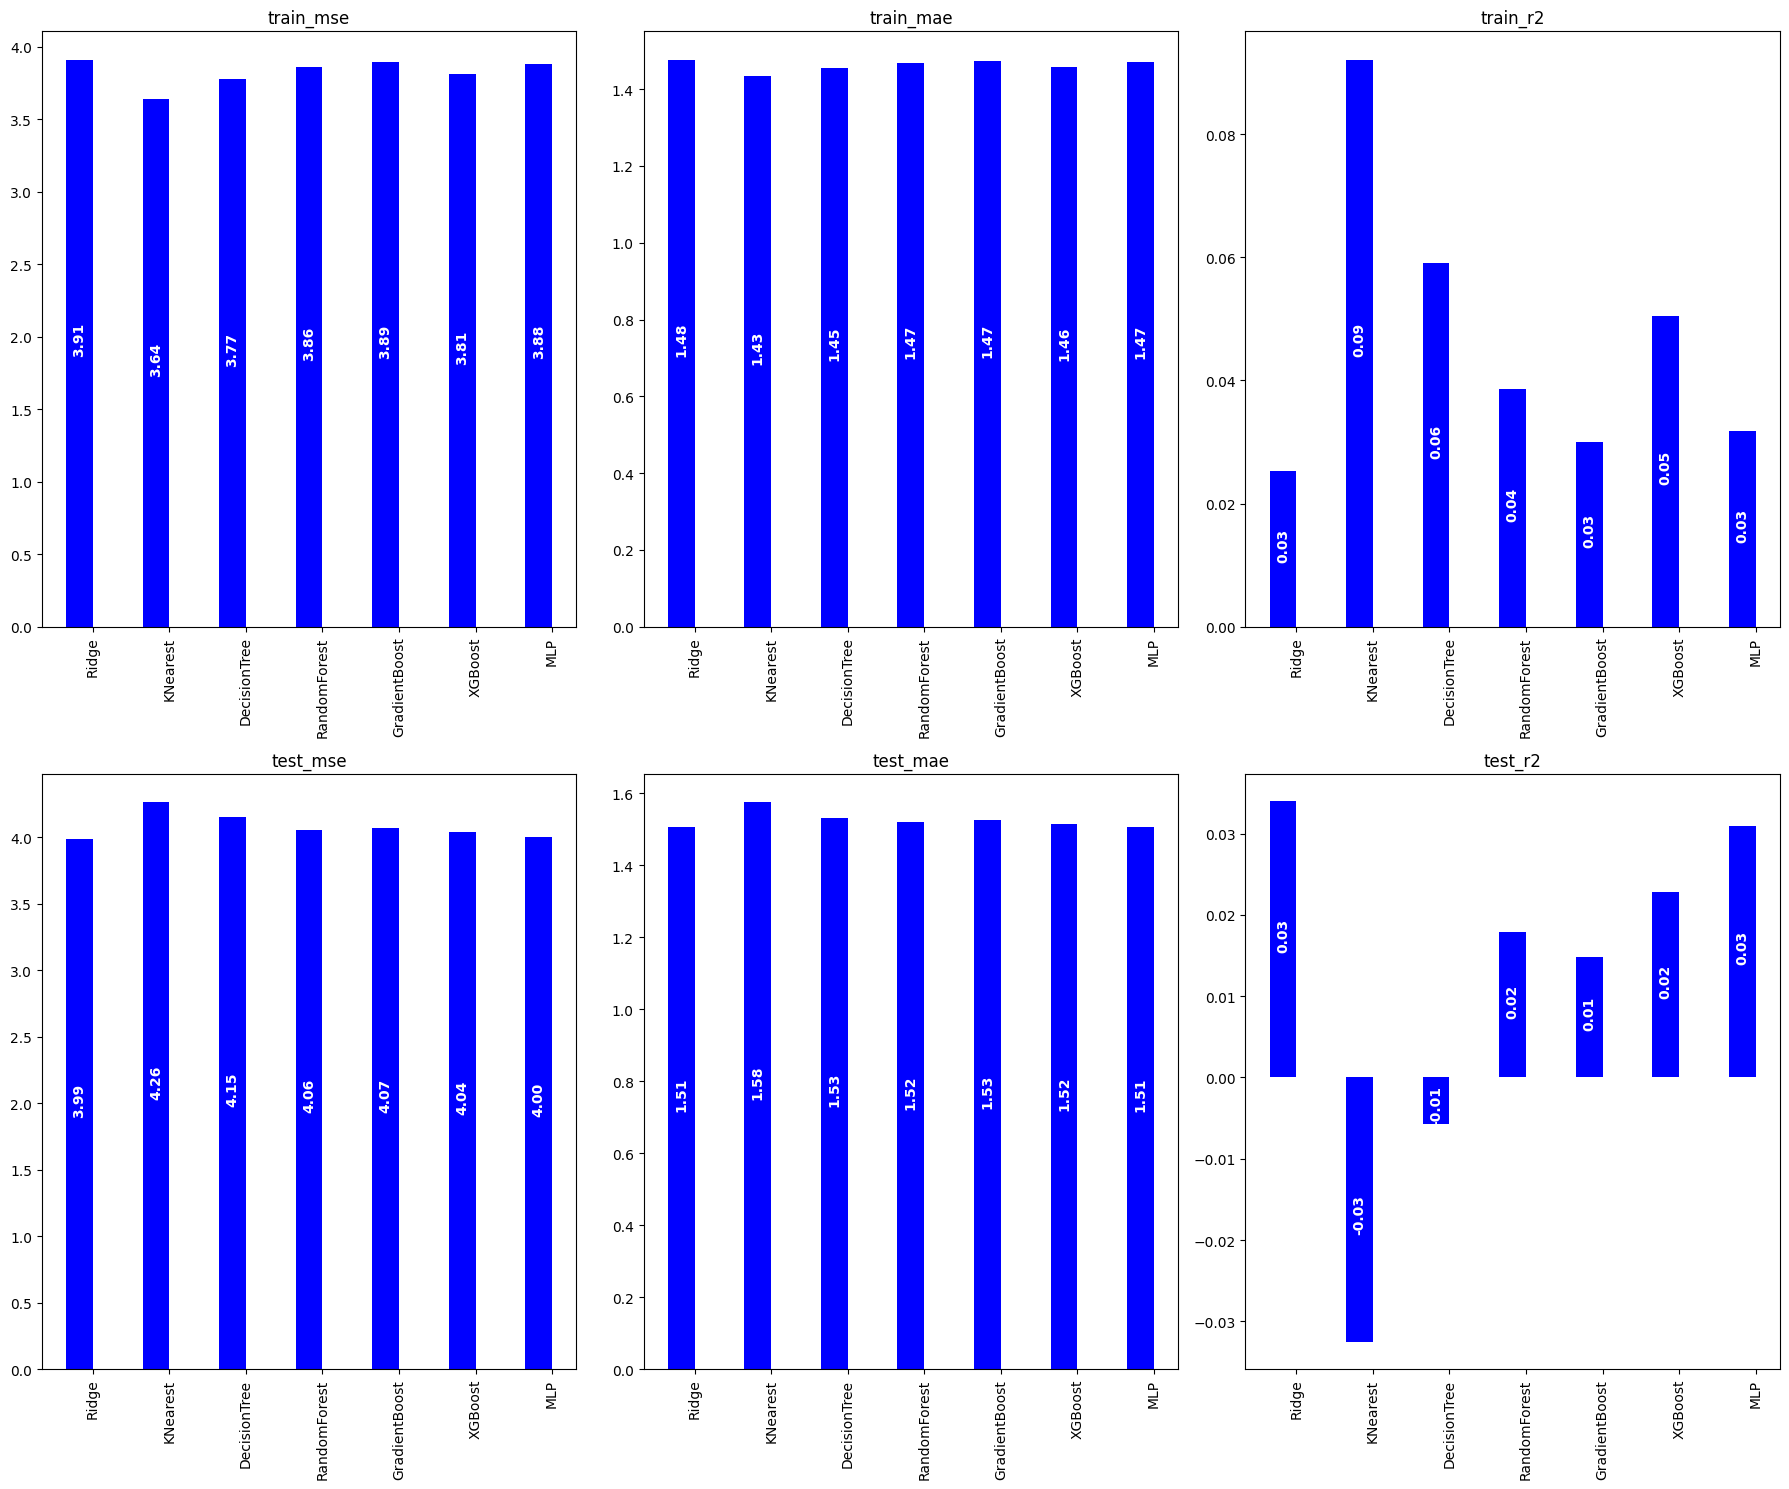

In [63]:
# Results for only Face++ feature for predicting the raised amount

raised_models_face = get_the_results(X_train, X_test, param_grid, 
                                      numerical_features   = ['beauty'], 
                                      categorical_features = ['gender','smile','emotion','age_group'], 
                                      text_feature         = [],
                                      columns_drop_list    = ['raised_amount'],
                                      target_list          = ['raised_amount'])

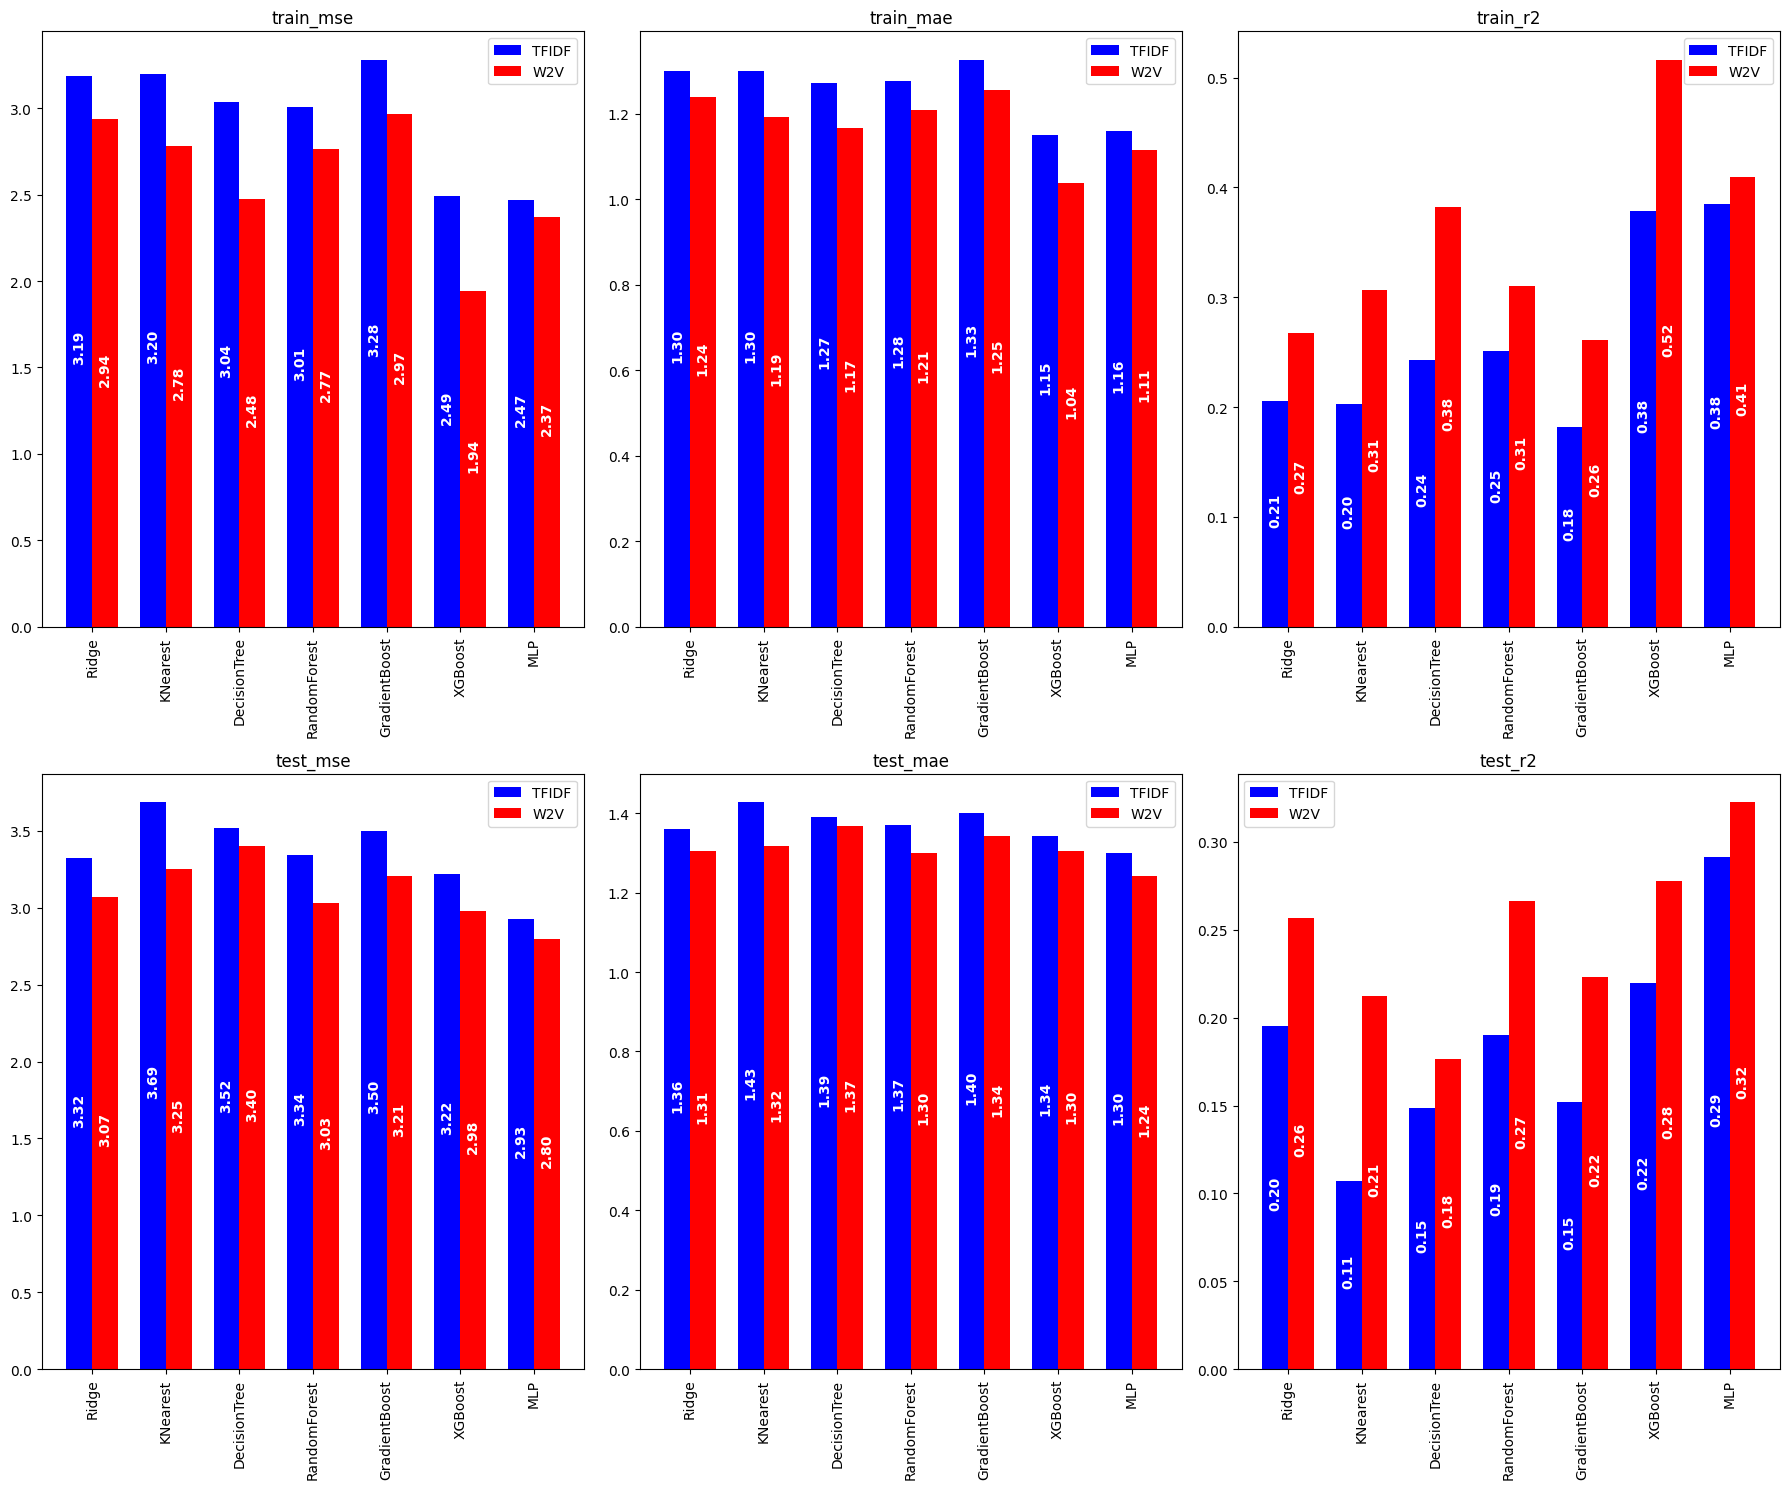

In [71]:
# Results for only text and Face++ feature for predicting the raised amount

raised_models_face = get_the_results(X_train, X_test, param_grid, 
                                      numerical_features   = ['beauty'], 
                                      categorical_features = ['gender','smile','emotion','age_group'], 
                                      text_feature         = text_feature,
                                      columns_drop_list    = ['raised_amount'],
                                      target_list          = ['raised_amount'])

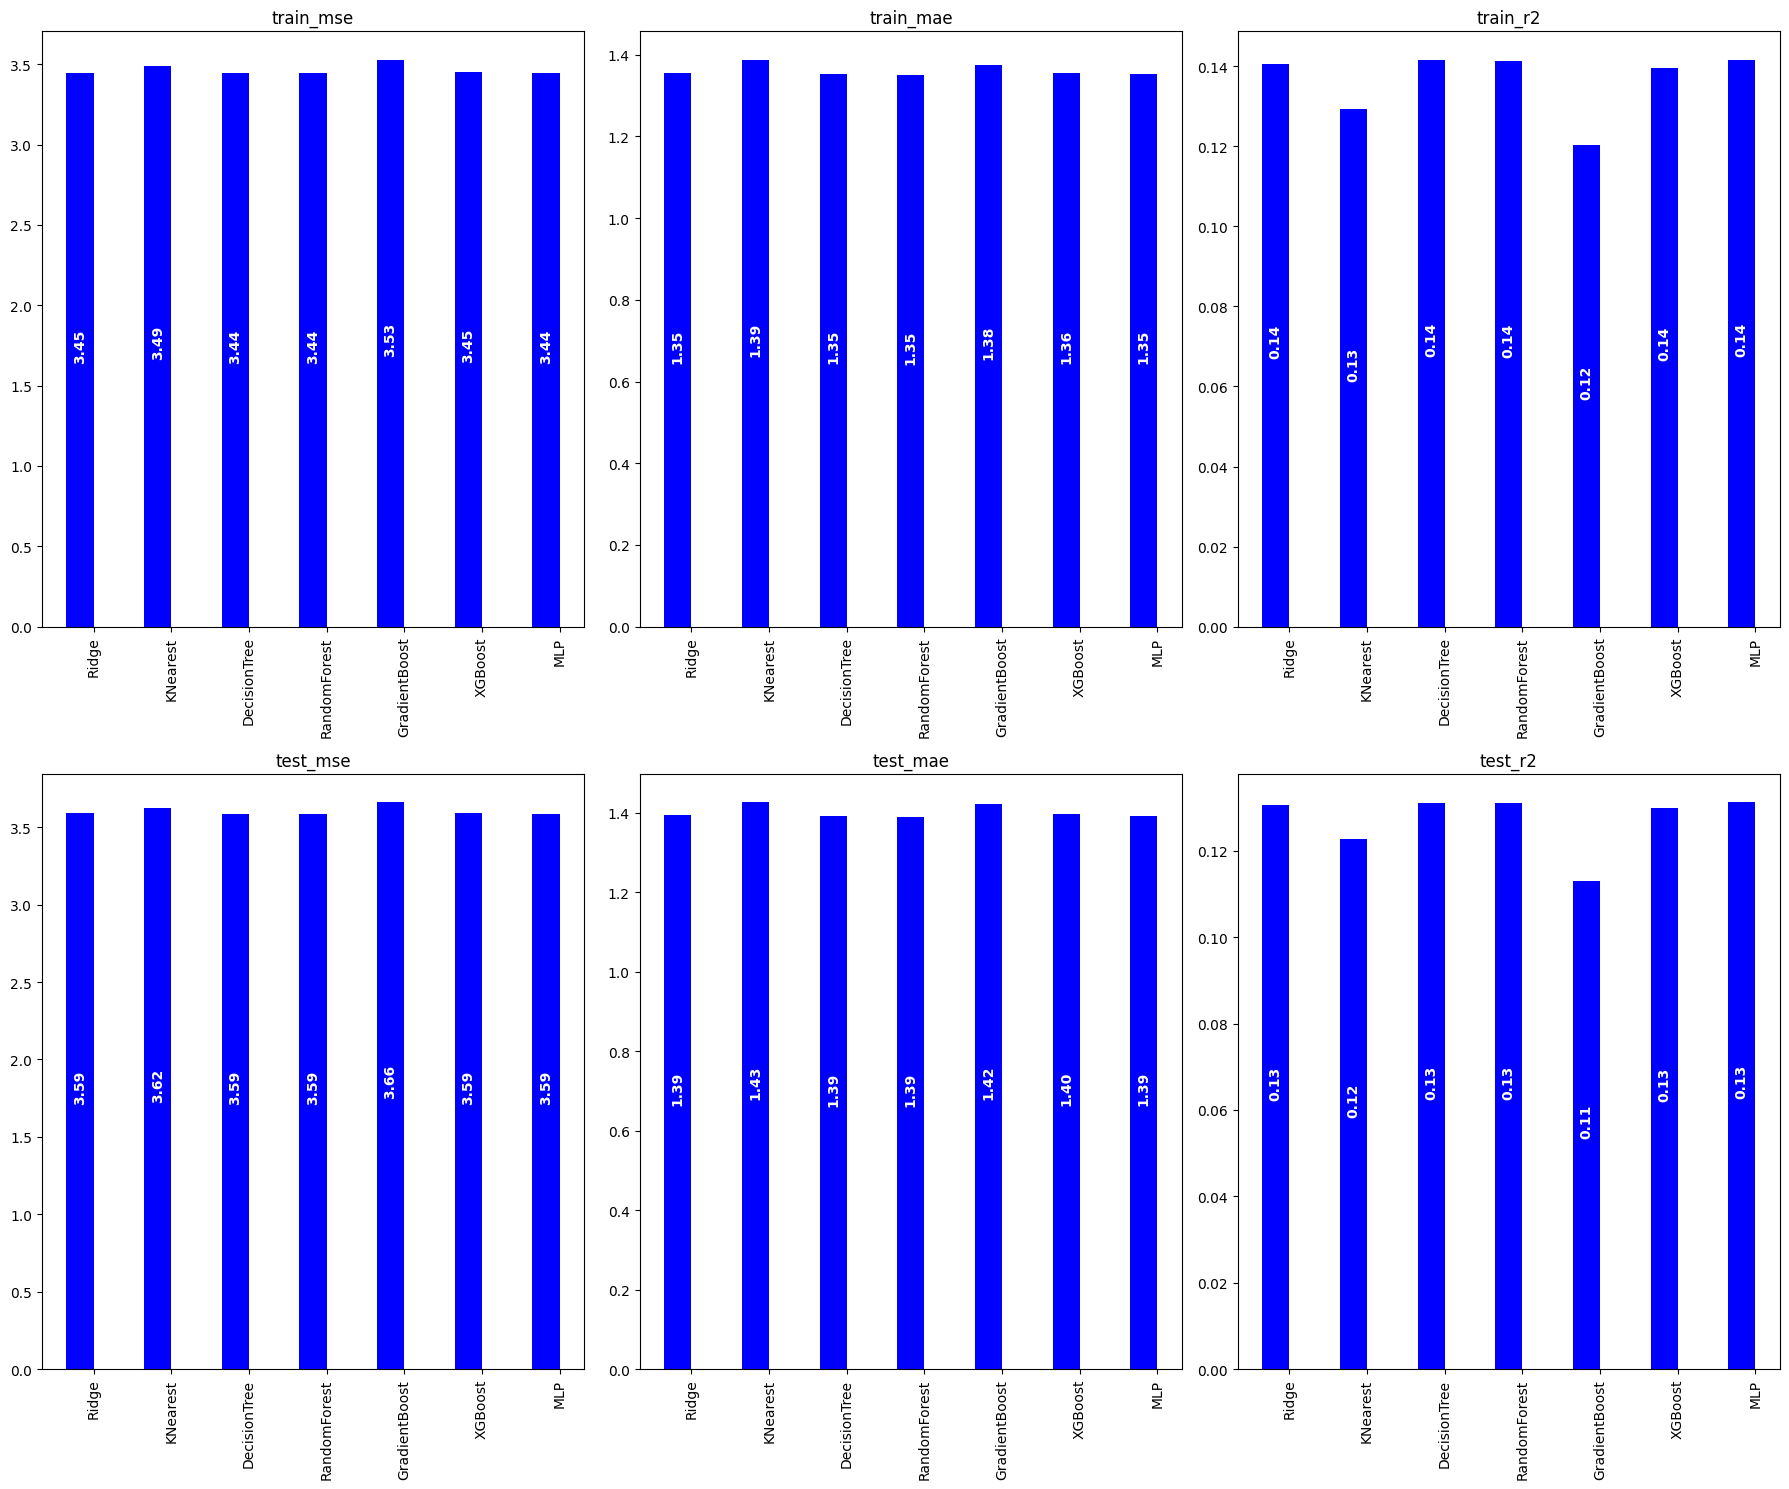

In [64]:
# Results for only urgency feature for predicting the raised amount

raised_models_urgency = get_the_results(X_train, X_test, param_grid, 
                                      numerical_features   = [], 
                                      categorical_features = ['urgency'], 
                                      text_feature         = [],
                                      columns_drop_list    = ['raised_amount'],
                                      target_list          = ['raised_amount'])

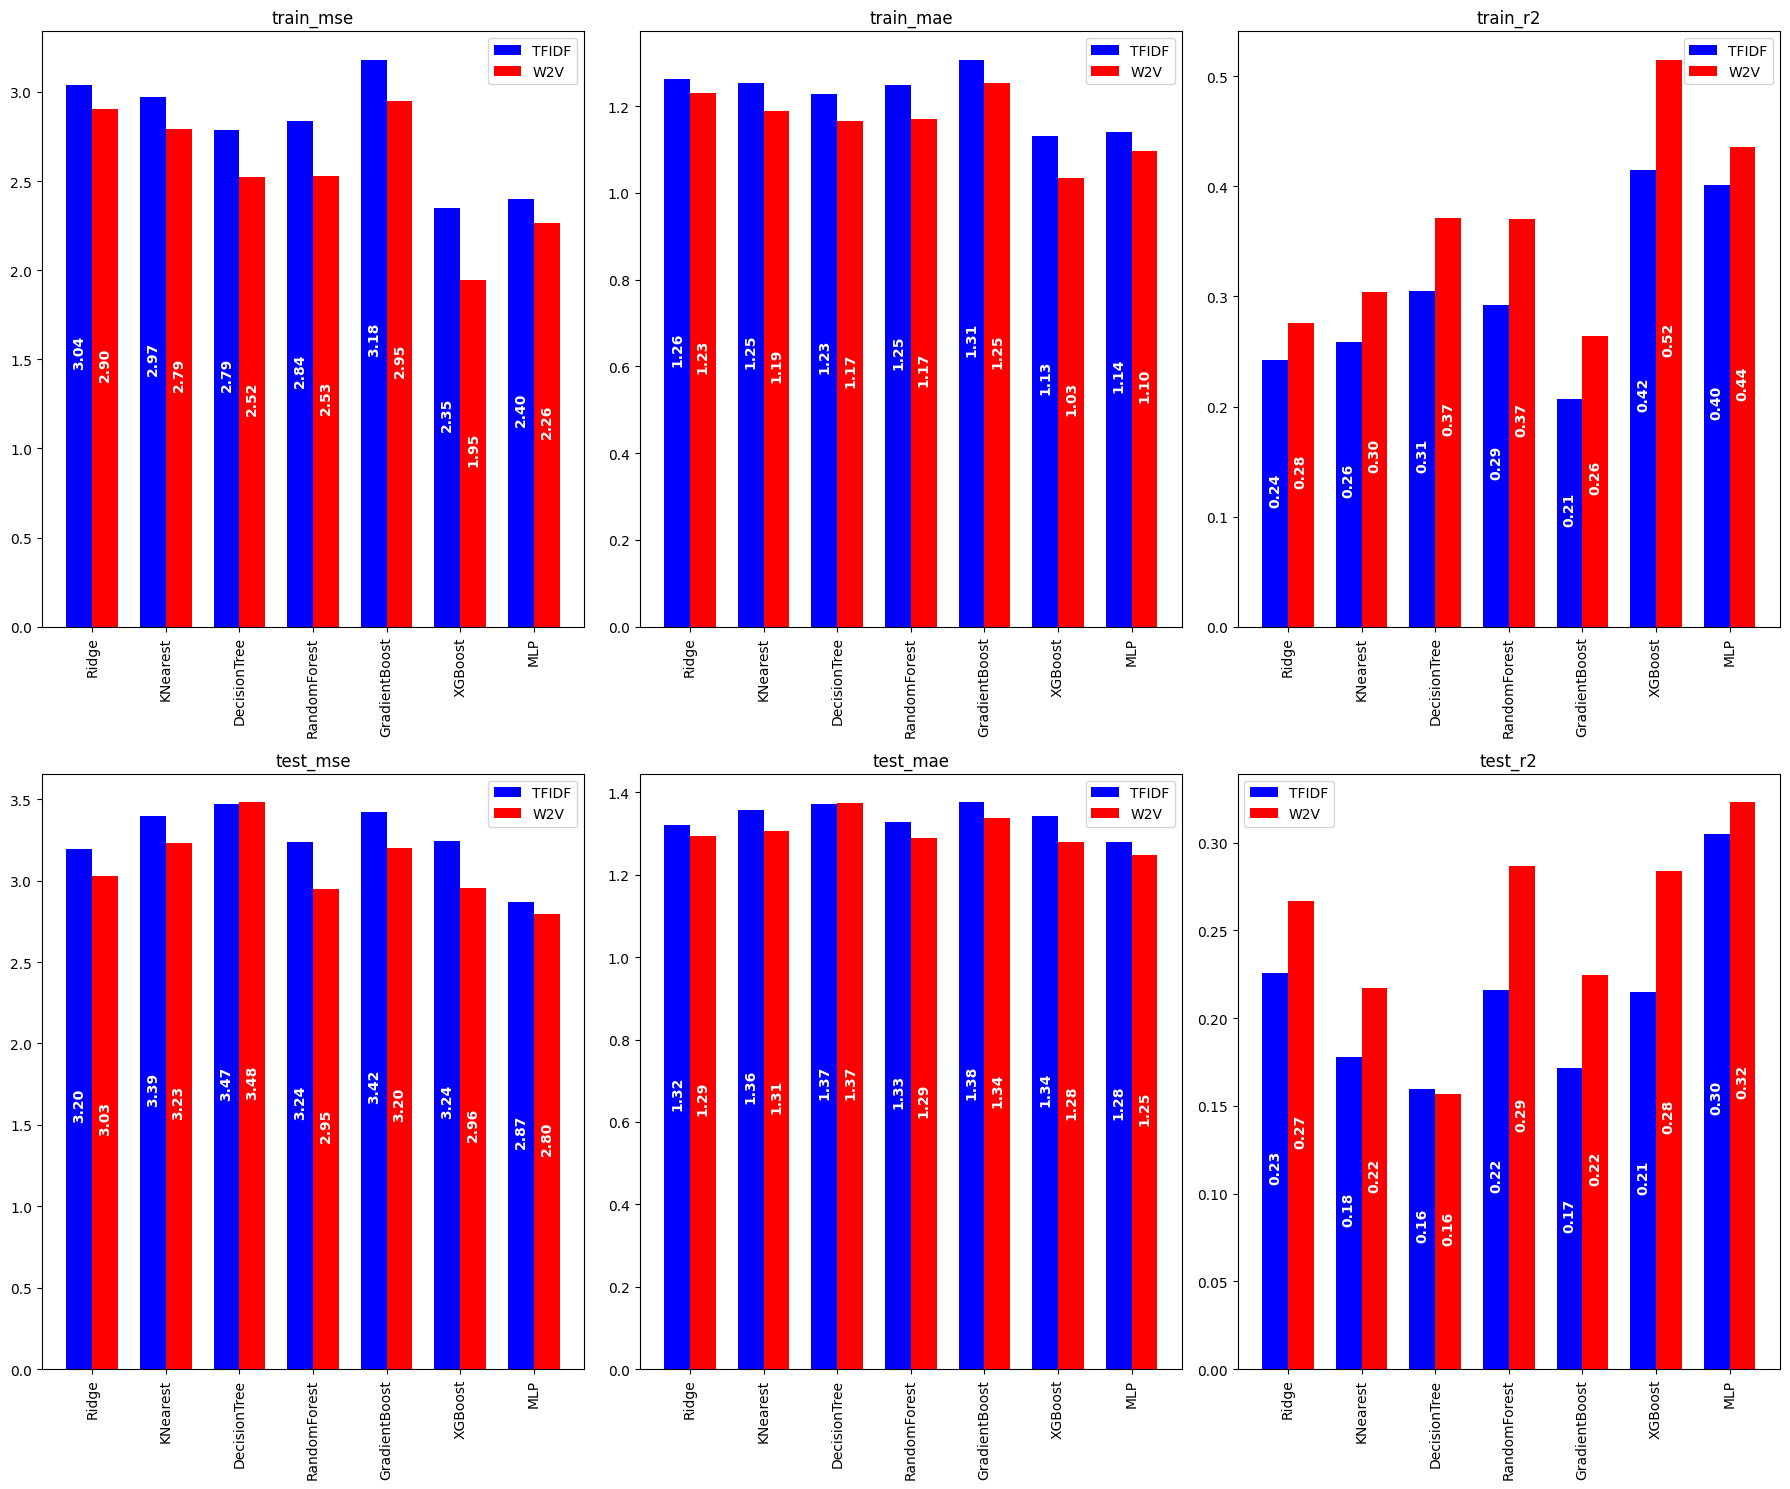

In [73]:
# Results for only text and Face++ and urgency feature for predicting the raised amount

raised_models_face = get_the_results(X_train, X_test, param_grid, 
                                      numerical_features   = ['beauty'], 
                                      categorical_features = ['gender','smile','emotion','age_group','urgency'], 
                                      text_feature         = text_feature,
                                      columns_drop_list    = ['raised_amount'],
                                      target_list          = ['raised_amount'])

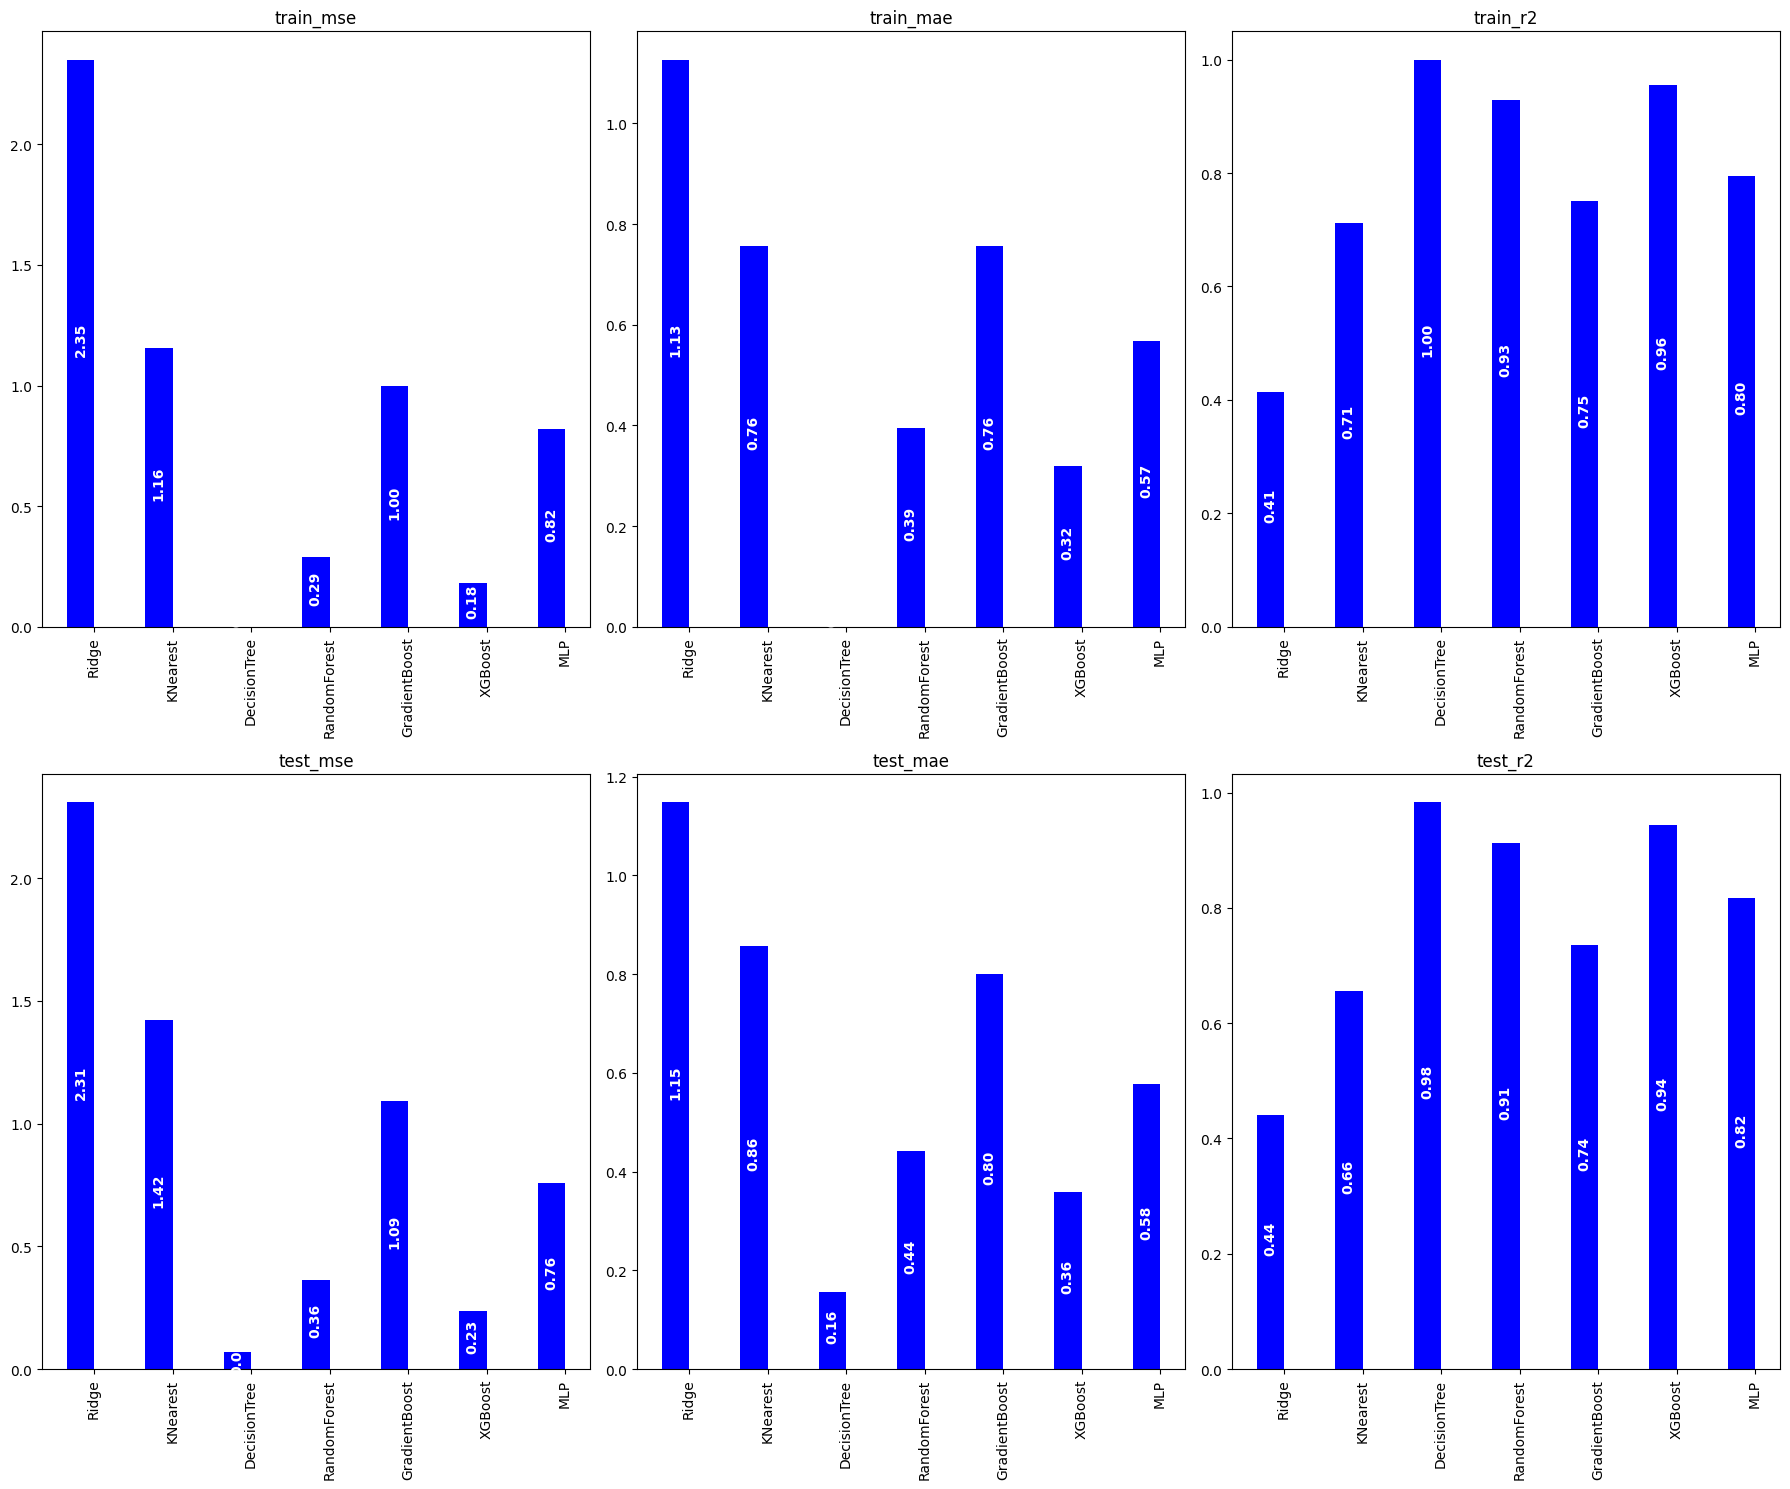

In [65]:
# Results for only numerical features for predicting the raised amount

raised_models_numerical = get_the_results(X_train, X_test, param_grid, 
                                numerical_features   = num_features_raised, 
                                categorical_features = [], 
                                text_feature         = [],
                                columns_drop_list    = ['raised_amount'],
                                target_list          = ['raised_amount'])

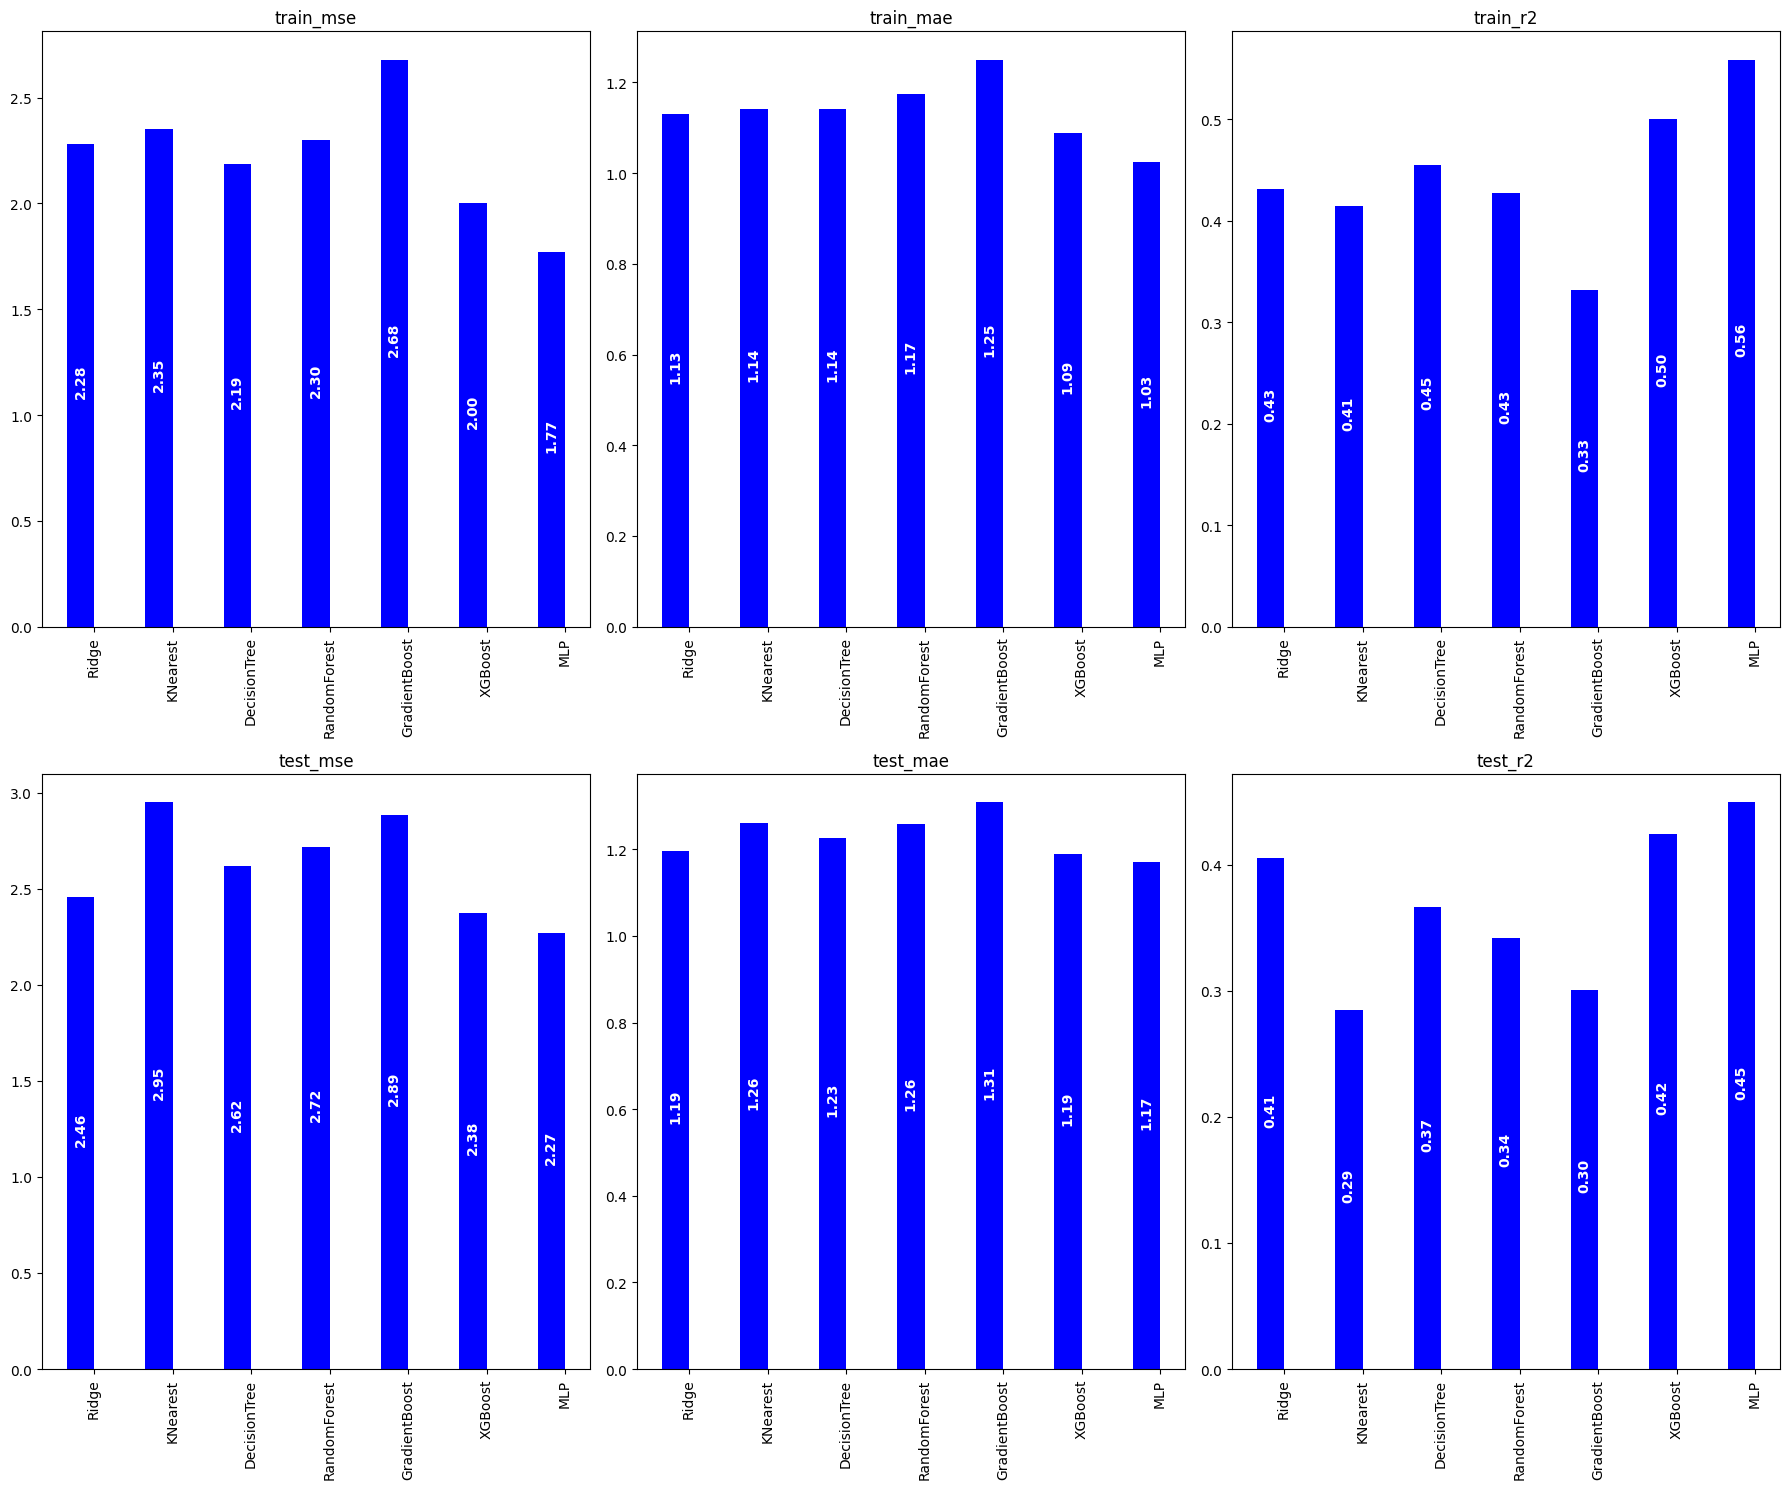

In [66]:
# Results for only categorical features for predicting the raised amount

raised_models_categorical = get_the_results(X_train, X_test, param_grid, 
                                numerical_features   = [], 
                                categorical_features = cat_features_raised, 
                                text_feature         = [],
                                columns_drop_list    = ['raised_amount'],
                                target_list          = ['raised_amount'])

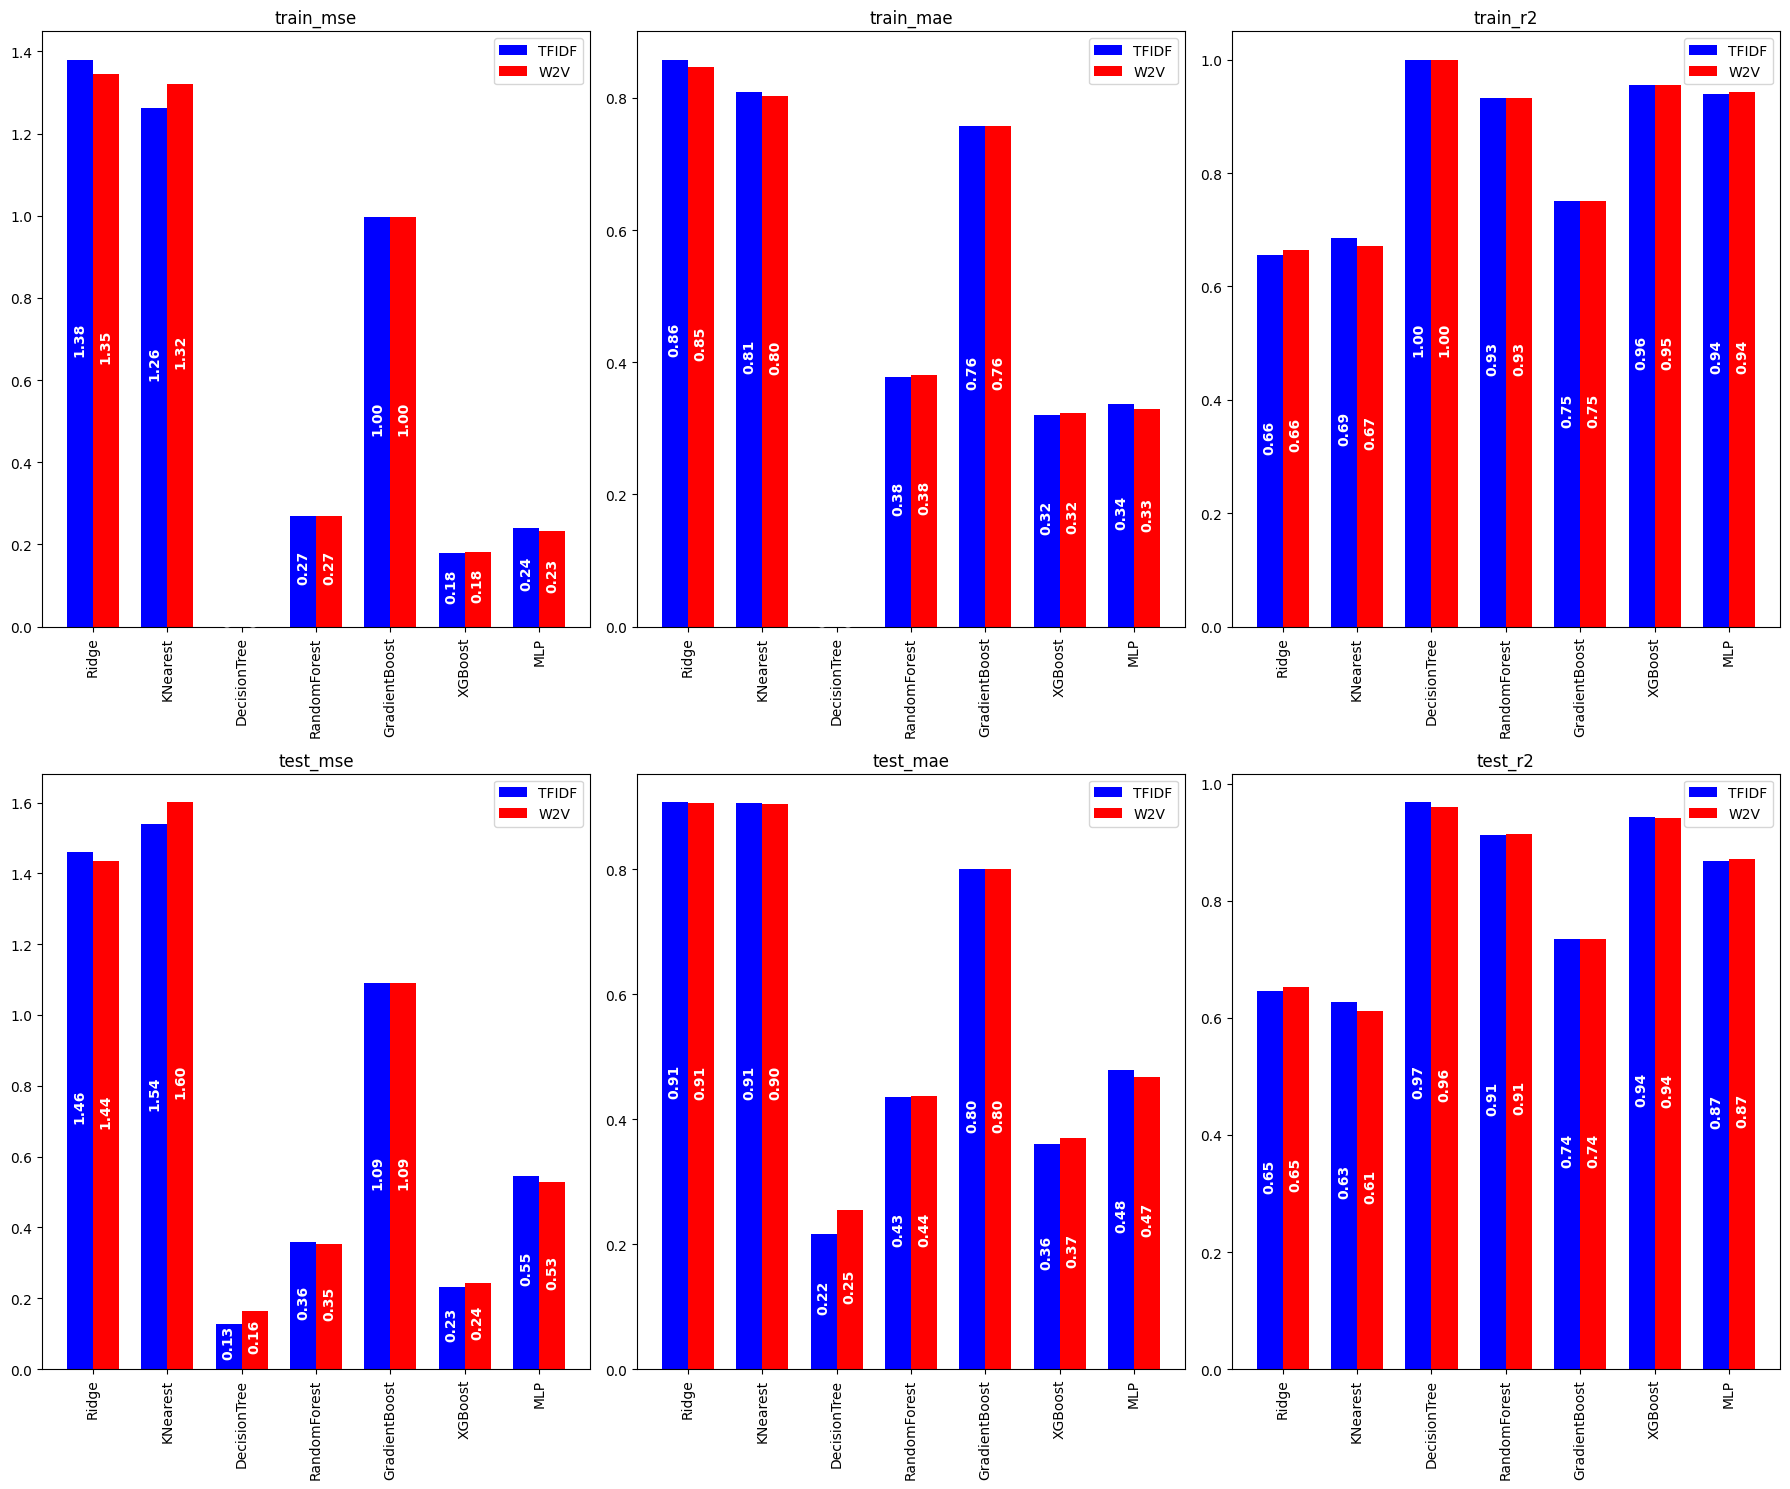

In [72]:
# Results for only all features(excluding urgency) for predicting the raised amount

raised_models_all = get_the_results(X_train, X_test, param_grid, 
                                numerical_features   = num_features_raised, 
                                categorical_features = ['category','state','gender','smile','emotion','age_group'], 
                                text_feature         = text_feature,
                                columns_drop_list    = ['raised_amount'],
                                target_list          = ['raised_amount'])

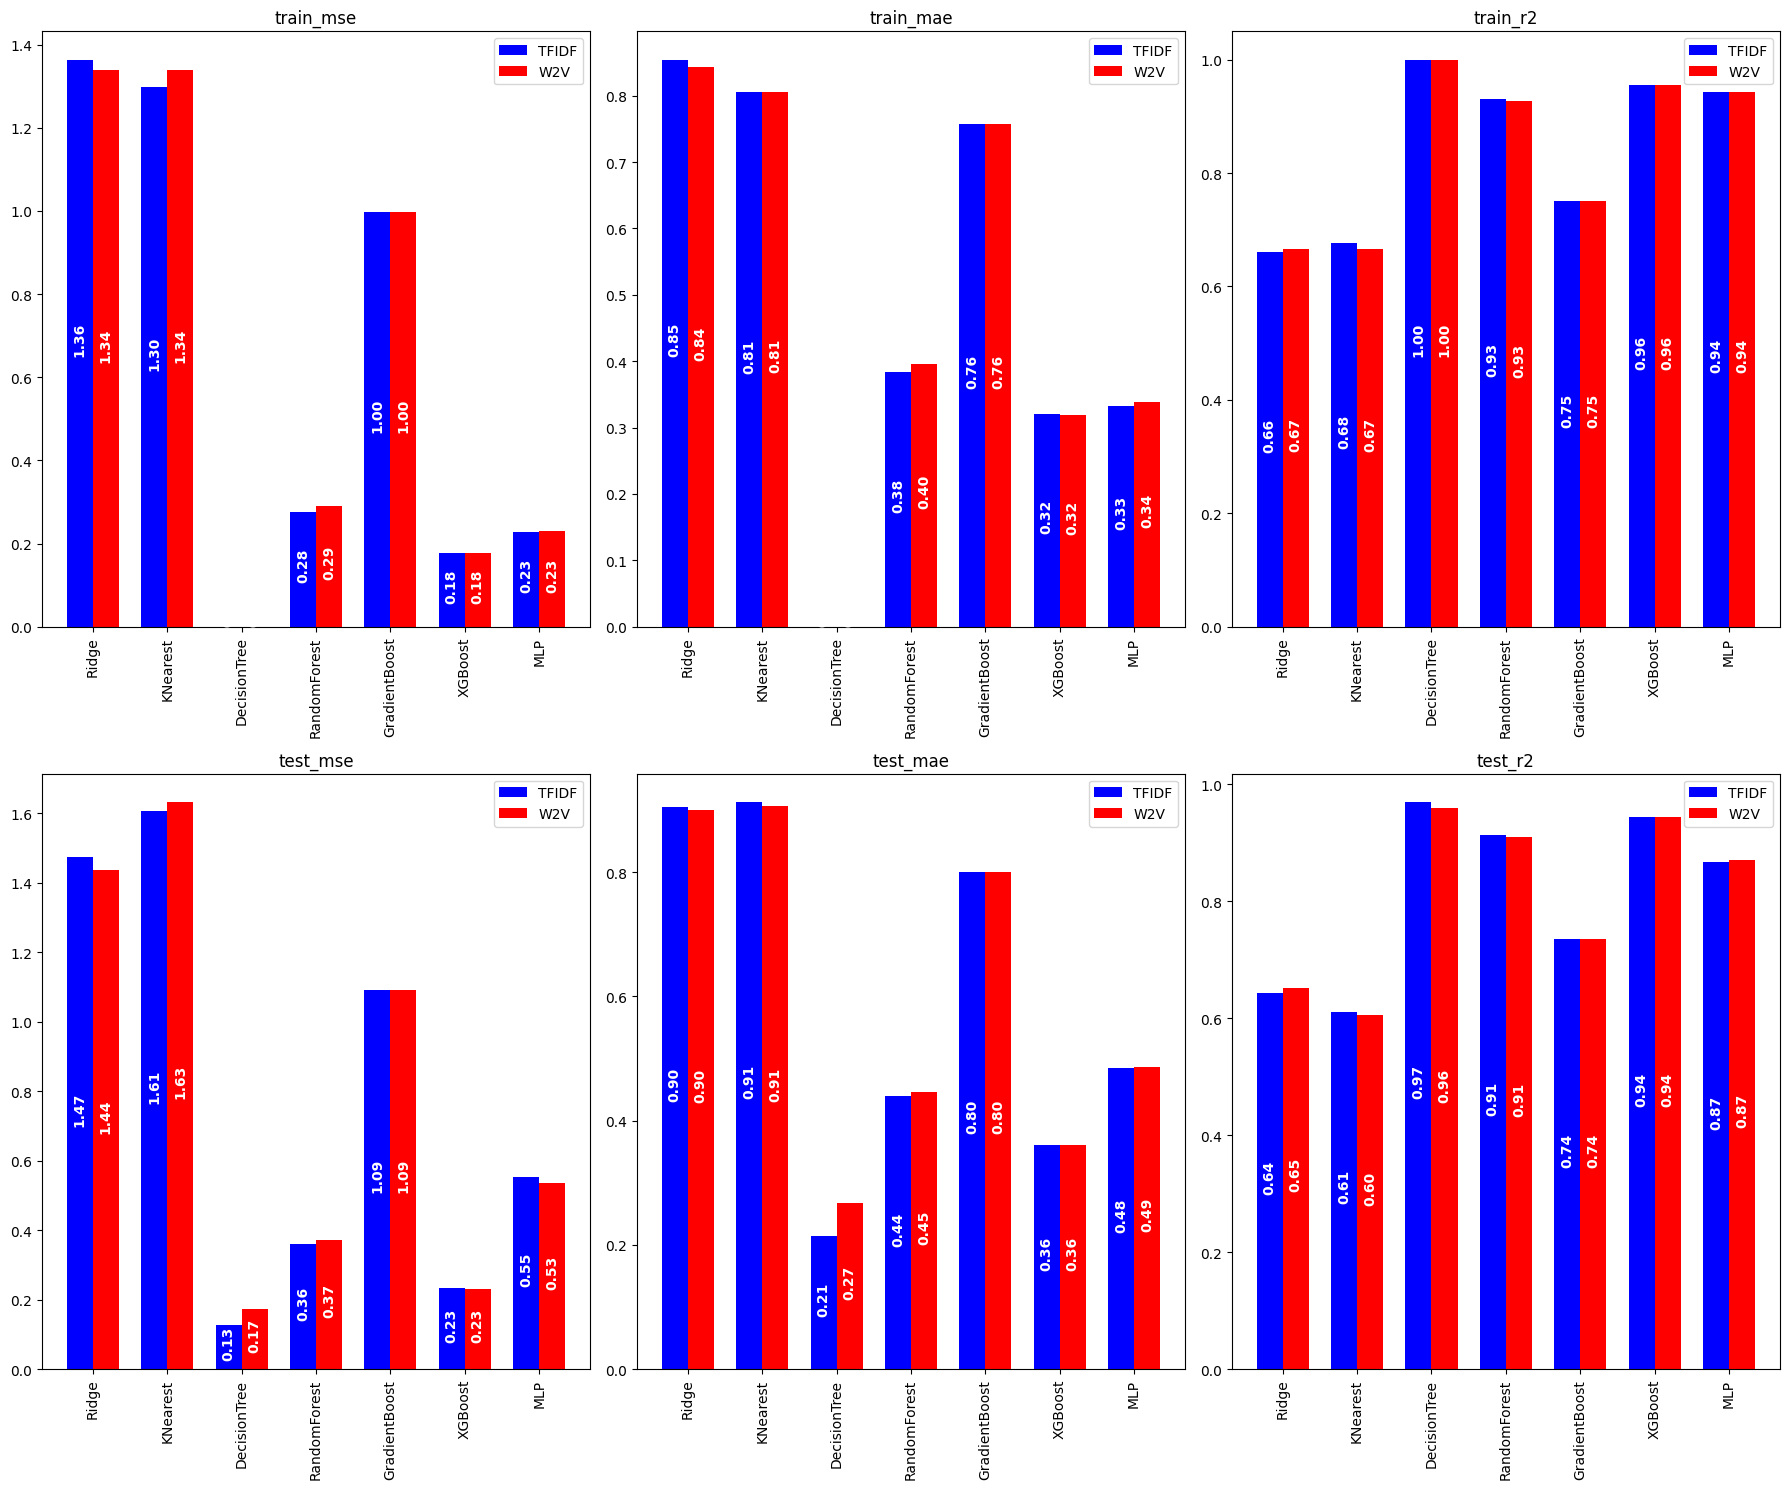

In [67]:
# Results for only all features for predicting the raised amount

raised_models_all = get_the_results(X_train, X_test, param_grid, 
                                numerical_features   = num_features_raised, 
                                categorical_features = cat_features_raised, 
                                text_feature         = text_feature,
                                columns_drop_list    = ['raised_amount'],
                                target_list          = ['raised_amount'])

Considering R2 Score as the selection criteria for choosing the best model, ***Decision Tree trained on all the features [text featurization - TFIDF]*** performed better with ***0.97 R2 score*** on test data. Hence, Decision Tree with TFIDF featurization is used for extracting best features and predictions for raised amount.

In [68]:
# Display the top 10 features along with their coefficient scores
print('The top 10 features in predicting the raised amount are:\n')

# Extract the preprocessor and regression steps
preprocessor = raised_models_all['DecisionTree_tfidf'].named_steps['preprocessor']
regressor    = raised_models_all['DecisionTree_tfidf'].named_steps['regressor']

# Get feature names and their coefficients
feature_names = preprocessor.get_feature_names_out()
coefficients  = regressor.feature_importances_

# Get the indices of the top 10 coefficients based on absolute values (magnitude)
top_indices = np.argsort(np.abs(coefficients))[::-1][:10]

# Print each top feature with its corresponding signed coefficient score
for i in top_indices:
    print(f"   {feature_names[i]:<40}: {coefficients[i]:.4f}")

The top 10 features in predicting the raised amount are:

   num__no_of_donations                    : 0.7034
   num__ratio                              : 0.2321
   num__goal_amount                        : 0.0565
   text_tfidf__family                      : 0.0005
   text_tfidf__little                      : 0.0004
   text_tfidf__well                        : 0.0003
   text_tfidf__health                      : 0.0003
   text_tfidf__world                       : 0.0003
   num__beauty                             : 0.0002
   num__word_len                           : 0.0002


1. *num__no_of_donations (0.7035)*:  
   This is the most dominant feature. The number of donations is a crucial predictor of the total raised amount. Campaigns that attract more donations are more likely to raise higher amounts, underlining the importance of donor engagement.

2. *num__ratio (0.2320)*:  
   This feature represents the ratio of the raised amount to the campaign goal. It indicates how close the campaign is to reaching its goal, which can inspire more donors to contribute as they see the campaign nearing its target.

3. *num__goal_amount (0.0568)*:  
   The total goal amount also influences the raised amount. While not as significant as the number of donations or the goal progress, the set goal amount still plays a role in determining how much will be raised. Campaigns with higher goals might attract more donations, though this effect is relatively weaker.

4. *text_tfidf__little (0.0004)*:  
   The word *little* in the campaign description may convey that even small donations are valuable. This can encourage potential donors who may otherwise hesitate to contribute, leading to more donors and collectively a larger raised amount.

5. *num__beauty (0.0003)*:  
   The *beauty* of the campaign, likely referring to its visual appeal, has a small but noticeable effect on donations. Well-designed and aesthetically pleasing campaigns tend to engage more people and inspire higher donations.

6. *text_tfidf__world (0.0003)*:  
   The word *world* in the campaign's text helps evoke a sense of global relevance. This suggests that the campaign has a wider impact, making potential donors feel that their contribution will have a far-reaching effect.

7. *text_tfidf__health (0.0003)*:  
   The word *health* indicates that the campaign is related to urgent, impactful causes, such as medical needs or healthcare access. This can create a strong emotional appeal, motivating people to donate.

8. *text_tfidf__help (0.0002)*:  
   The word *help* is a direct and emotionally compelling call to action. It encourages potential donors to contribute by highlighting the need for support, which can lead to an increased amount raised.

9. *cat__emotion_neutral (0.0002)*:  
   This categorical feature represents a neutral emotional tone in the campaign. While campaigns with a neutral tone may still attract donations, those with more emotionally charged language are likely to drive more contributions.

10. *num__word_len (0.0002)*:  
   The length of the campaign description can slightly influence the raised amount. Longer descriptions might provide more detail and context, helping to engage potential donors and encouraging higher donations.


**Summary:**
The most dominant predictors of the raised amount are numeric features like *the number of donations*, *goal progress ratio*, and *goal amount*. These features directly drive how much will be raised, with more donations and higher goal achievement leading to more funds. *Text-based features* such as certain words in the campaign description (like *little*, *world*, *health* and *help*) influence the outcome by making the cause more emotionally compelling or globally relevant. The *emotional tone* of the campaign (neutral) and *visual appeal* (beauty) also play a role, although their impact is secondary compared to the numeric features. The campaign category, such as *emotion-neutral* tone, can slightly contribute to the overall funds raised.

**Prediction on sample data using the best model obtained above**

*Prediction 1*

In [146]:
import copy

In [147]:
# This particular dataset is for sept 22nd.
sample = subset_data.sample(1).reset_index(drop=True)
sample.head()

title  raised_amount  goal_amount        date_span  \
0  help fight stage colon cancer          13070        50000  Created 2 d ago   

                                               story  no_of_donations  \
0  first foremost tough post write thank taking t...             83.0   

                                           image_url     organizer  \
0  https://images.gofundme.com/RuLdorQsFjgMkuAX0u...  uriye  jahja   

                   location  \
0  North Richland Hills, TX   

                                       campaign_link  ... duration_days  \
0  https://www.gofundme.com//f/support-care-for-s...  ...             2   

   gender  smile    emotion  beauty age_group   ratio  \
0  female    yes  happiness  74.062     adult  0.2614   

                                                text  word_len urgency  
0  help fight stage colon cancer first foremost t...        88  medium  

[1 rows x 22 columns]

In [148]:
# This would give me comparisons for the Sept 22nd data.
def compare(sample,best_model_donations,best_model_raised):
    
    actual_donations    = sample['no_of_donations'].values[0]
    predicted_donations = np.expm1(best_model_donations.predict(sample)[0])
    print('Actual no of donations - ',actual_donations)
    print('Predicted no of donations - ',int(predicted_donations))
    actual_raised  = sample['raised_amount'].values[0]
    predicted_raised = np.expm1(best_model_raised.predict(sample)[0])
    print('')
    print('Actual raised amount - ',actual_raised)
    print('Predicted raised amount - ',round(predicted_raised,2))
    
    return None

In [149]:
# This would give me comparisons for the Sept 22nd data.
compare(sample, donations_models_all['RandomForest_w2v'], raised_models_all['DecisionTree_tfidf'])

Actual no of donations -  83.0
Predicted no of donations -  89

Actual raised amount -  13070
Predicted raised amount -  13070.0


In [150]:
from datetime import datetime
def days_difference_from_fixed_date():
    """
    Calculate the difference in days between a given fixed date and the current date.
    Parameters:
    fixed_date_str (str): A string representing the fixed date (e.g., "September 22nd, 2024").
    Returns:
    int: The number of days between the fixed date and today. A positive value means the fixed date is in the future,
         and a negative value means the fixed date is in the past.
    """
    # Convert the fixed date string to a datetime object
    fixed_date = datetime.strptime('September 22nd, 2024', "%B %dnd, %Y")
    
    # Get the current date
    current_date = datetime.today()
    
    # Calculate the difference in days
    difference = (current_date - fixed_date).days
    
    return difference

In [151]:
# Predictions for the current date
def current_day_results(sample, best_model_donations, best_model_raised):
    
    data   = copy.deepcopy(sample)
    data['duration_days'] = data['duration_days'].apply(lambda x: x + days_difference_from_fixed_date())
    donations_pred          = int(np.expm1(best_model_donations.predict(data)[0]))
    data['no_of_donations'] = donations_pred
    raised_pred             = np.expm1(best_model_raised.predict(data)[0])
    
    print('Predicted no of donations - ',donations_pred)
    print('Predicted raised amount   - ',raised_pred)
    
    return None

In [152]:
# Predictions for the current date
current_day_results(sample, donations_models_all['XGBoost_w2v'],raised_models_all['XGBoost_w2v'])

Predicted no of donations -  113
Predicted raised amount   -  7682.1577


In [153]:
sample['campaign_link'].values[0]

'https://www.gofundme.com//f/support-care-for-stage-4-colon-cancer?qid=176a246d835e044d8fac5c67078d9135'

#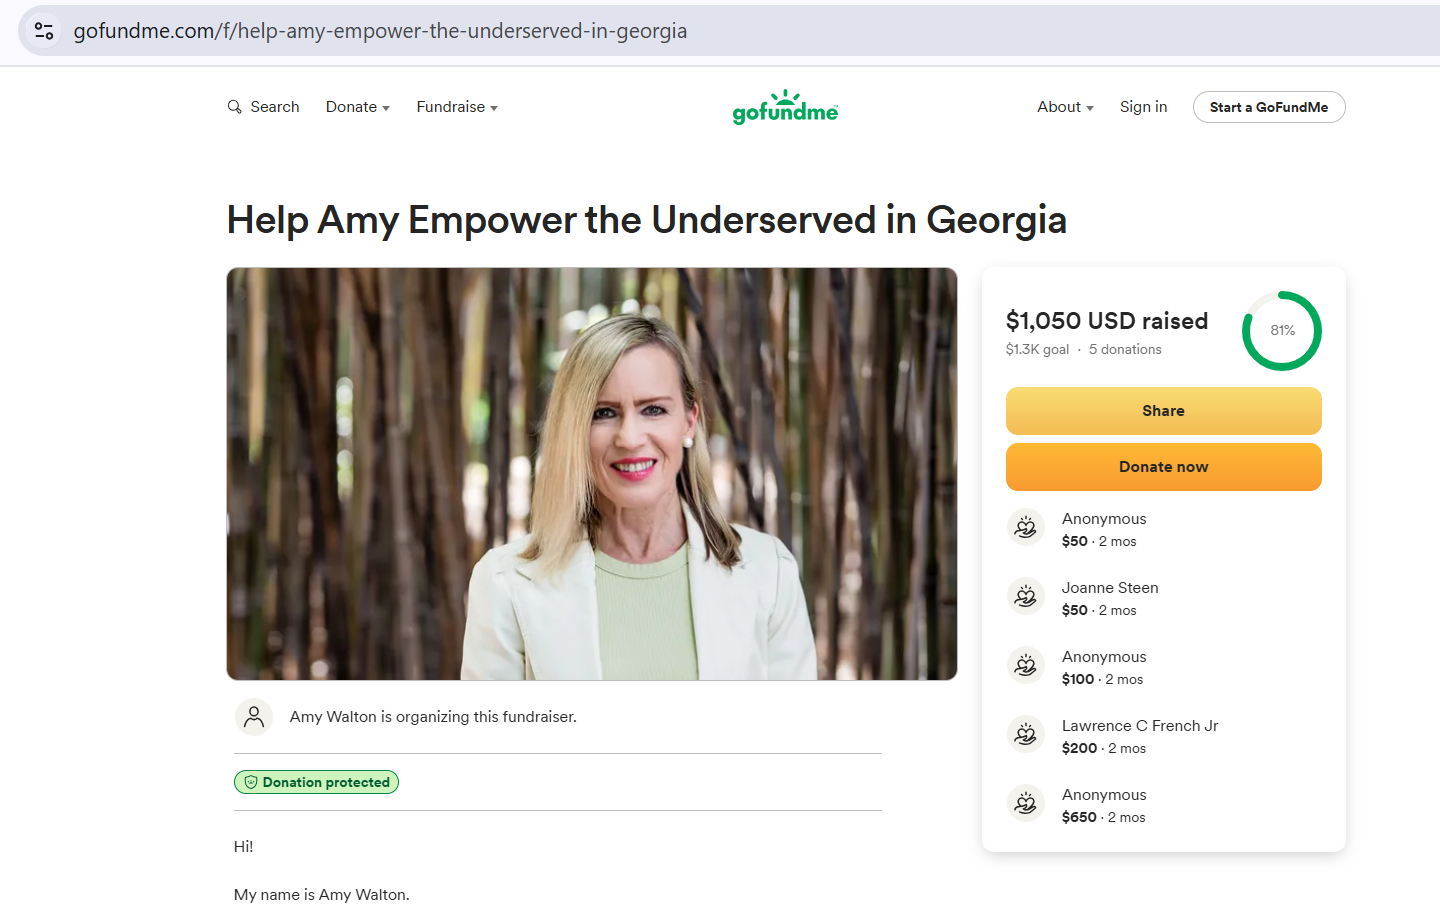

*Prediction 2*

In [95]:
sample_2 = subset_data.sample(1,random_state=25).reset_index(drop=True)
sample_2.head()

title  raised_amount  goal_amount  \
0  support good deed gone wrong            620         3500   

                 date_span                                              story  \
0  Created July 21st, 2024  help friend fine young college trying succeed ...   

   no_of_donations                                          image_url  \
0             16.0  https://images.gofundme.com/Kptr624X5QtRfO_ieW...   

         organizer     location  \
0  Travis Anderson  Helotes, TX   

                                       campaign_link  ... duration_days  \
0  https://www.gofundme.com//f/support-dustin-a-g...  ...            63   

  gender  smile    emotion  beauty age_group     ratio  \
0   male    yes  happiness  67.809     adult  0.177143   

                                                text  word_len urgency  
0  support good deed gone wrong help friend fine ...        45  medium  

[1 rows x 22 columns]

In [96]:
# result comparison for sept 22nd data
compare(sample_2, donations_models_all['RandomForest_w2v'], raised_models_all['DecisionTree_tfidf'])

Actual no of donations -  16.0
Predicted no of donations -  11

Actual raised amount -  620
Predicted raised amount -  620.0


In [97]:
# Current date results
current_day_results(sample_2, donations_models_all['RandomForest_w2v'], raised_models_all['DecisionTree_tfidf'])

Predicted no of donations -  11
Predicted raised amount   -  495.00000000000017


In [98]:
sample_2['campaign_link'].values[0]

'https://www.gofundme.com//f/support-dustin-a-good-deed-gone-wrong?qid=5187ad6b39322614acfce829d8d63dea'

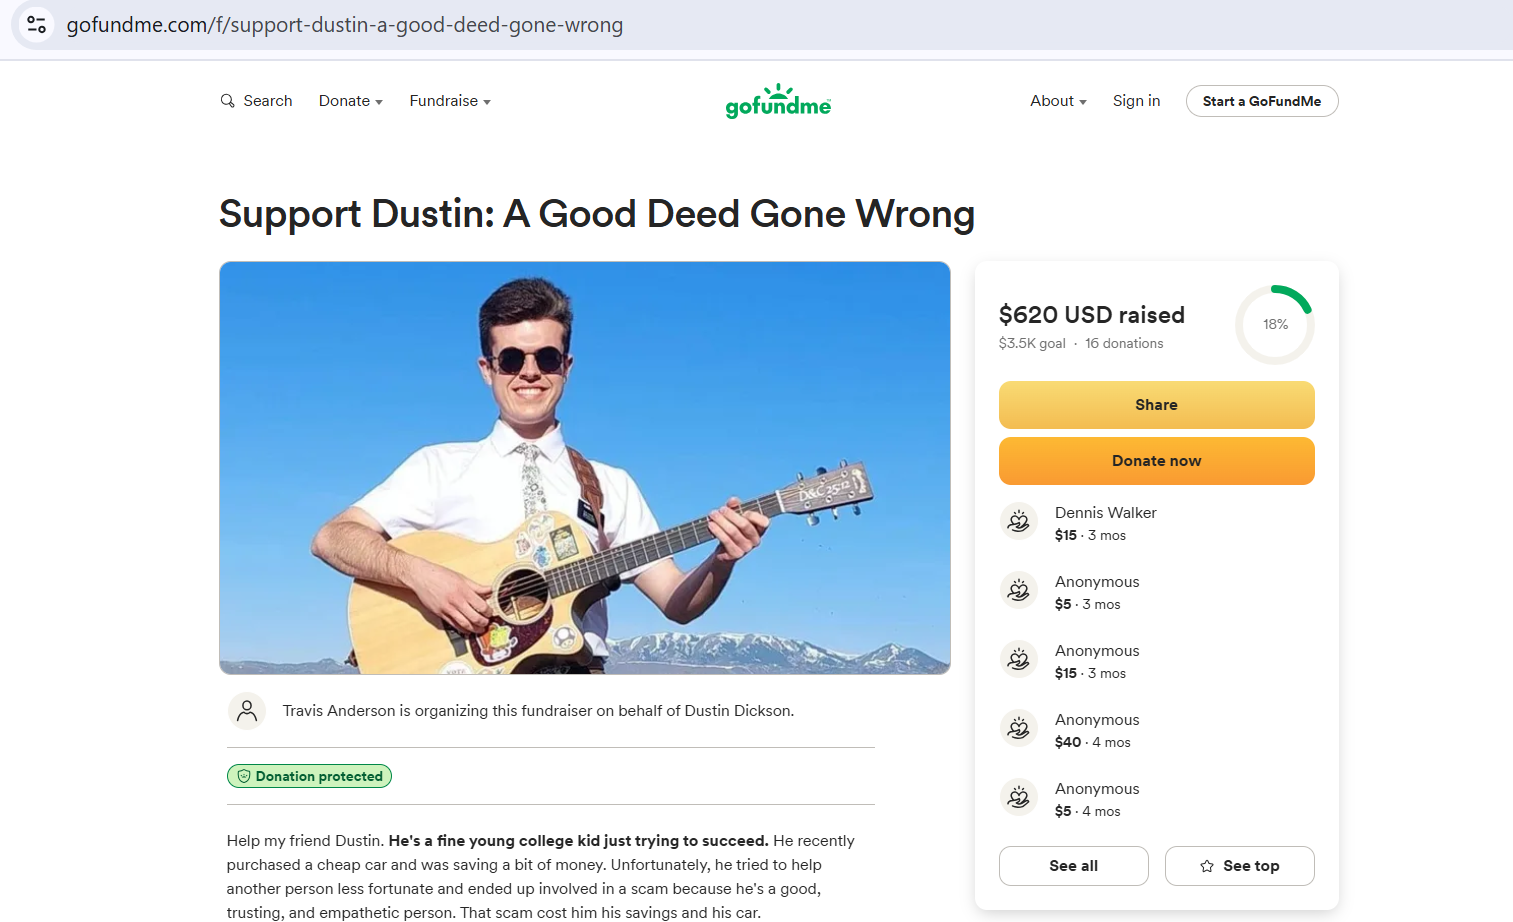

*Prediction 3*

In [81]:
sample_3 = subset_data.sample(1,random_state=42).reset_index(drop=True)
sample_3.head()

title  raised_amount  goal_amount  \
0  support journey camp accomplish           1350         2800   

                 date_span                                              story  \
0  Created June 23rd, 2024  share accepted camp accomplish camp authentic ...   

   no_of_donations                                          image_url  \
0             30.0  https://images.gofundme.com/UxUplhll8z-CfZIHr5...   

         organizer              location  \
0  Destinee Savage  Friendship Acres, MD   

                                       campaign_link  ... duration_days  \
0  https://www.gofundme.com//f/support-messiahs-j...  ...            91   

  gender  smile    emotion  beauty age_group     ratio  \
0   male    yes  happiness  48.377     child  0.482143   

                                                text  word_len urgency  
0  support journey camp accomplish share accepted...       134     low  

[1 rows x 22 columns]

In [82]:
# result comparison for sept 22nd data
compare(sample_3, donations_models_all['RandomForest_w2v'], raised_models_all['DecisionTree_tfidf'])

Actual no of donations -  30.0
Predicted no of donations -  23

Actual raised amount -  1350
Predicted raised amount -  1485.0


In [83]:
# Current date results
current_day_results(sample_3, donations_models_all['RandomForest_w2v'], raised_models_all['DecisionTree_tfidf'])

Predicted no of donations -  23
Predicted raised amount   -  1345.0000000000002


In [84]:
sample_3['campaign_link'].values[0]

'https://www.gofundme.com//f/support-messiahs-journey-to-camp-accomplish?qid=8569fadc9fce5a9d54e0a67edf608b71'

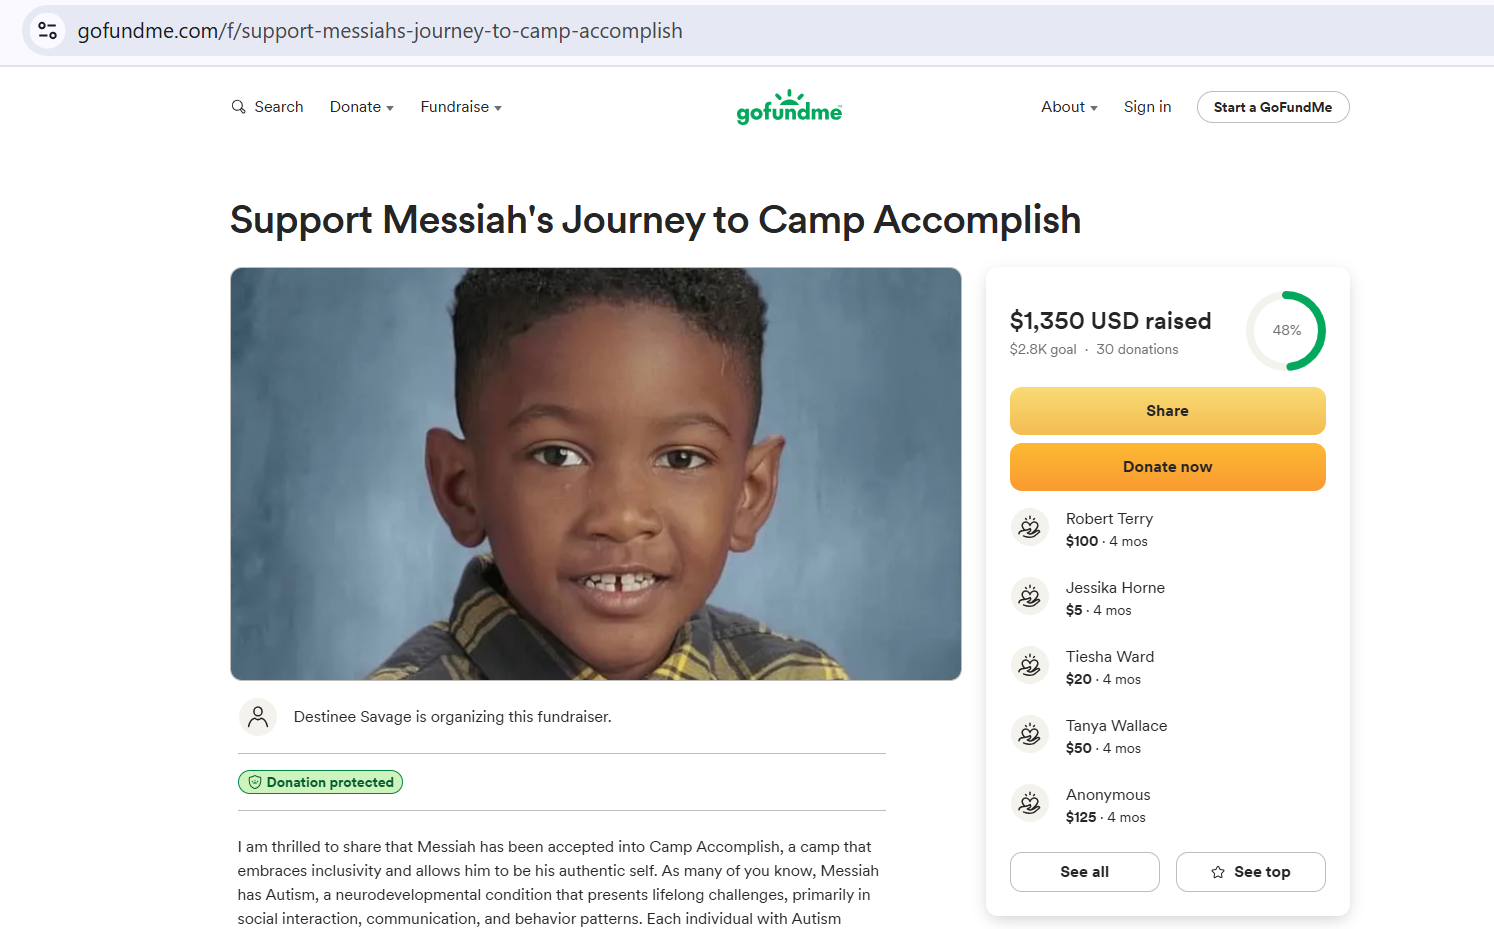